# Thesis

This notebook demonstrates a full pipeline for hard drive failure prediction using both LSTM (deep learning) and Decision Tree (CT) models.

You will:
- Train and test the LSTM model
- Train and test the Decision Tree model on raw data
- Generate LSTM predictions for all drives
- Test a random drive using the LSTM model
- Feed the LSTM results into the Decision Tree and analyze the outcome

**Requirements:**  
- All dependencies installed (see `requirements.txt`)
- Data available in `data`
- LSTM and CT code available in `notebooks/LSTM/smart.py` and `notebooks/CT/CT.py`

TODO: make sure the models are always saved in the correct folder on root/models

# Index

1. [Thesis Overview](#thesis)
2. [Setup](#setup)
3. [Feature Selection & Correlation Analysis](#generate-a-correlation-matrix-to-see-the-best-features-to-use)
4. [Preprocessing Data](#preprocess-data)
5. [Imputation of Missing Values](#imputación-de-datos-faltantes)
6. [Categorical Variable Encoding](#codificación-de-variables-categóricas)
7. [Ordinal Encoding of Capacity](#convirtiendo-a-categórica-ordinal-capacity_bytes)
8. [Model Training and Evaluation](#step-2-load-the-data-to-train-the-models)
    - [LSTM Model](#step-3-train-the-lstm-model)
    - [Decision Tree Model](#step-4-train-and-test-the-decision-tree-ct-on-raw-data)
9. [Predictions and Visualization](#step-4-generate-predictions)
10. [Pipeline: LSTM + Decision Tree](#now-we-will-predict-a-hard-drive-with-the-lstm-and-consume-it-and-classify-the-prediction-result-with-the-ct)

In [46]:
# Step 1: Setup and Imports

import os
import sys
from typing import Optional
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import joblib
import json
from datetime import datetime
from sklearn.metrics import classification_report
import random
from joblib import load
import seaborn as sns
from feature_engine.imputation import RandomSampleImputer

# Add project root and submodules to sys.path for imports
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, "notebooks/LSTM"))
sys.path.append(os.path.join(project_root, "notebooks/CT"))

import notebooks.LSTM.smart as smart
import notebooks.CT.CT as CT
from notebooks.LSTM.smart import Net


# Setup

Set the variables for the data paths and the features to be used in the models.

In [2]:
ct_data_path = "../data"
lstm_data_path = "../data/data_test"
days_to_train = 3
days_to_predict = 2
verbose = True

#LSTM parameters
num_features = 12 # For default SMART data, this should match the number of features in your dataset
n_neurons = 4
num_epochs = 1
learning_rate = 0.001

lstm_param_grid = {
    'n_neurons': [4, 8, 16, 32],
    'learning_rate': [0.001, 0.003, 0.005, 0.01],
    'batch_size': [2, 4, 8, 16]
}

#CT parameters
ct_depth = 100
ct_leaf = 15

ct_param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, None],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 40, 50]
}

In [3]:

# Set device for torch: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Generate a correlation matrix to see the best features to use.

In [4]:
from itertools import combinations

# Load data for correlation analysis
ct_raw_data = CT.importdata(ct_data_path)


Processing subfolders: 100%|██████████| 10/10 [33:02<00:00, 198.21s/it]

Dataset Length:  28908
Dataset Shape:  (28908, 187)
Dataset:          failure  smart_1_normalized  smart_1_raw  smart_2_normalized  \
244236    False               100.0          0.0               100.0   
299107    False               100.0          0.0               148.0   
106180    False               100.0          0.0               138.0   
78820     False                84.0  237326944.0                 0.0   
177056    False               100.0          0.0               100.0   

        smart_2_raw  smart_3_normalized  smart_3_raw  smart_4_normalized  \
244236          0.0               100.0       8209.0               100.0   
299107         48.0                84.0        328.0               100.0   
106180         96.0                95.0        230.0               100.0   
78820           0.0                93.0          0.0               100.0   
177056          0.0               100.0       7757.0               100.0   

        smart_4_raw  smart_5_normalized  ...  sm

In [5]:
print("Columns in ct_raw_data:", ct_raw_data.columns.tolist())


Columns in ct_raw_data: ['failure', 'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized', 'smart_2_raw', 'smart_3_normalized', 'smart_3_raw', 'smart_4_normalized', 'smart_4_raw', 'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized', 'smart_7_raw', 'smart_8_normalized', 'smart_8_raw', 'smart_9_normalized', 'smart_9_raw', 'smart_10_normalized', 'smart_10_raw', 'smart_11_normalized', 'smart_11_raw', 'smart_12_normalized', 'smart_12_raw', 'smart_13_normalized', 'smart_13_raw', 'smart_15_normalized', 'smart_15_raw', 'smart_16_normalized', 'smart_16_raw', 'smart_17_normalized', 'smart_17_raw', 'smart_18_normalized', 'smart_18_raw', 'smart_22_normalized', 'smart_22_raw', 'smart_23_normalized', 'smart_23_raw', 'smart_24_normalized', 'smart_24_raw', 'smart_27_normalized', 'smart_27_raw', 'smart_71_normalized', 'smart_71_raw', 'smart_82_normalized', 'smart_82_raw', 'smart_90_normalized', 'smart_90_raw', 'smart_160_normalized', 'smart_160_raw', 'smart_161_normalized', 'smart_161_raw', '

In [6]:
# Compute correlation matrix for all numeric columns
correlation_matrix = ct_raw_data.corr()

# Get absolute correlation with 'failure' and sort descending (excluding 'failure' itself)
feature_corr = correlation_matrix['failure'].abs().drop('failure').sort_values(ascending=False)

# Get all features with nonzero correlation to failure
best_features = feature_corr[feature_corr > 0].index.tolist()

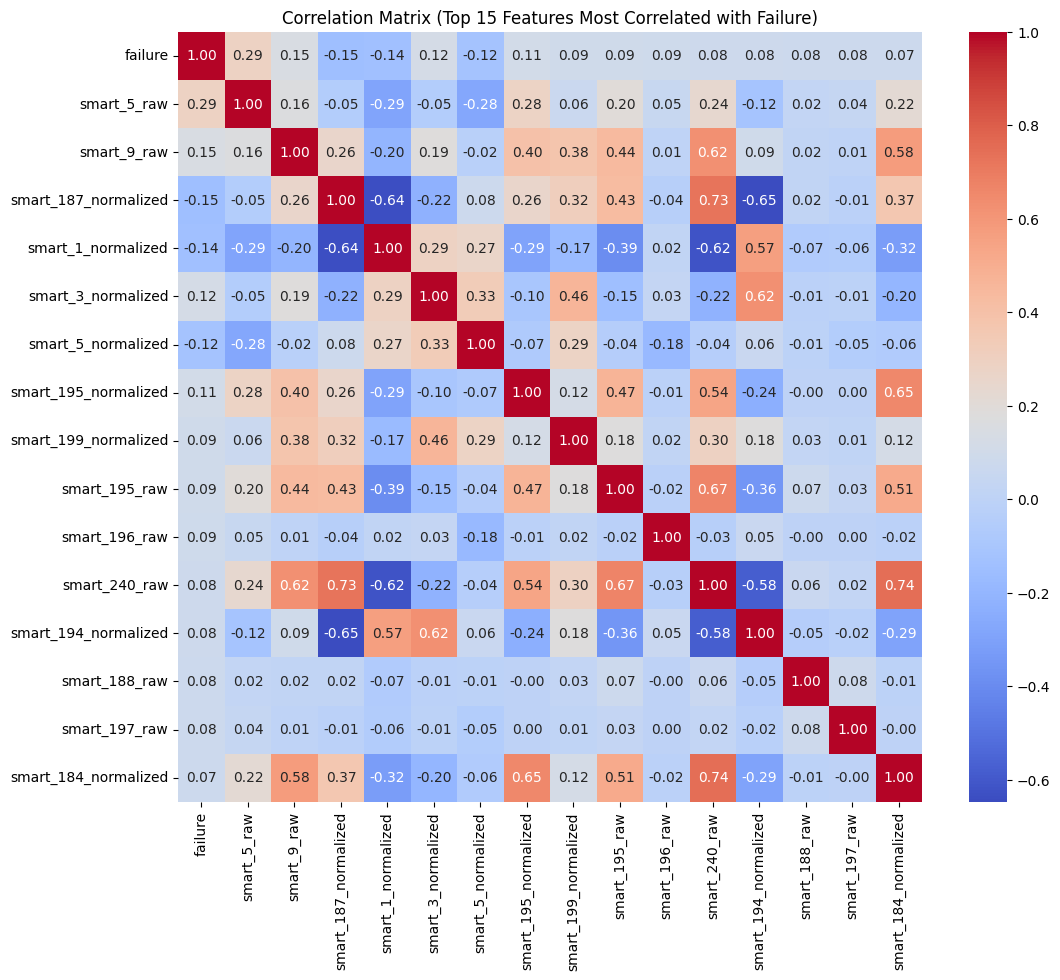

In [7]:


# Plot the correlation matrix for the top 15 features most correlated with failure
top_n = 15
top_corr_features = feature_corr.head(top_n).index.tolist()
corr_subset = correlation_matrix.loc[['failure'] + top_corr_features, ['failure'] + top_corr_features]

plt.figure(figsize=(12, 10))
plt.title(f"Correlation Matrix (Top {top_n} Features Most Correlated with Failure)")
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [8]:
# Print features and their correlation values
print("Best features by correlation with failure:")
for feature in best_features:
    print(f"{feature}: {feature_corr[feature]:.4f}")
    normalized_rows = [int(feature.split('_')[1]) for feature in best_features if 'normalized' in feature and feature_corr[feature] > 0.15]
    raw_rows = [int(feature.split('_')[1]) for feature in best_features if 'raw' in feature and feature_corr[feature] > 0.15]


Best features by correlation with failure:
smart_5_raw: 0.2903
smart_9_raw: 0.1508
smart_187_normalized: 0.1451
smart_1_normalized: 0.1418
smart_3_normalized: 0.1221
smart_5_normalized: 0.1217
smart_195_normalized: 0.1061
smart_199_normalized: 0.0945
smart_195_raw: 0.0945
smart_196_raw: 0.0923
smart_240_raw: 0.0837
smart_194_normalized: 0.0821
smart_188_raw: 0.0795
smart_197_raw: 0.0774
smart_184_normalized: 0.0745
smart_189_normalized: 0.0736
smart_187_raw: 0.0714
smart_198_raw: 0.0708
smart_12_raw: 0.0665
smart_222_normalized: 0.0614
smart_9_normalized: 0.0605
smart_198_normalized: 0.0591
smart_24_normalized: 0.0546
smart_23_normalized: 0.0545
smart_4_raw: 0.0538
smart_226_raw: 0.0536
smart_220_raw: 0.0531
smart_3_raw: 0.0528
smart_8_raw: 0.0505
smart_220_normalized: 0.0483
smart_193_raw: 0.0478
smart_226_normalized: 0.0477
smart_223_normalized: 0.0456
smart_224_normalized: 0.0440
smart_2_normalized: 0.0403
smart_71_normalized: 0.0403
smart_90_normalized: 0.0399
smart_90_raw: 0.0399


In [9]:
print("Normalized features with >0.15 correlation:", normalized_rows)
print("Raw features with >0.15 correlation:", raw_rows)

# Changinge the number of features used based on correlation analysis results
num_features = len(normalized_rows) + len(raw_rows)
print(f"Total number of features used: {num_features}")

Normalized features with >0.15 correlation: []
Raw features with >0.15 correlation: [5, 9]
Total number of features used: 2


## Preprocess data

In [10]:
columns_to_delete = [ 'datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num', 'is_legacy_format']
df = CT.importdata(ct_data_path, normalized_rows, raw_rows, columns_to_delete)

Processing subfolders: 100%|██████████| 10/10 [33:18<00:00, 199.88s/it]

Dataset Length:  28908
Dataset Shape:  (28908, 191)
Dataset:                date serial_number                model  capacity_bytes  \
244236  2025-01-01  8180A0ZCFVKG  TOSHIBA MG08ACA16TA     -2147483648   
299107  2025-01-01      1PGY8TJY  WDC WUH722222ALE6L4     -2147483648   
106180  2025-01-01      QBGUP2JT  WDC WUH721414ALE6L4     -1073741824   
78820   2025-01-01      ZL2P83JJ        ST16000NM001G     -2147483648   
177056  2025-01-01  61A0A0NBF97G  TOSHIBA MG07ACA14TA     -1073741824   

        failure  smart_1_normalized  smart_1_raw  smart_2_normalized  \
244236    False               100.0          0.0               100.0   
299107    False               100.0          0.0               148.0   
106180    False               100.0          0.0               138.0   
78820     False                84.0  237326944.0                 0.0   
177056    False               100.0          0.0               100.0   

        smart_2_raw  smart_3_normalized  ...  smart_250_normalized

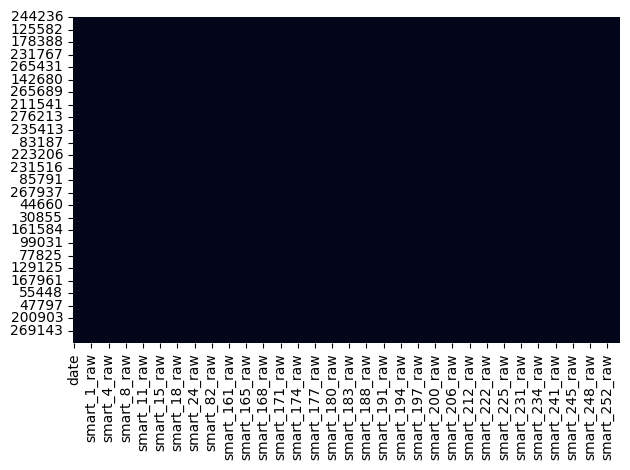

In [11]:
sns.heatmap(df.isnull(), cbar=False)
plt.tight_layout()  # Adjust the layout to ensure nothing is cut off
plt.show()
# plt.savefig(f'../reports/figures/heat_maps/heat_map_.png')
plt.close()

Ahora eliminaremos las columnas que solo tienen datos faltantes.

In [12]:
nan_columns = df.columns[df.isna().all()].tolist()
print(f"Columns with only NaN values: {nan_columns}")

df = df.drop(columns=nan_columns)

Columns with only NaN values: []


Imprimimos las columnas y los elementos que más aparecen para hacernos una idea de que que haremos con los distintos datos.

In [13]:
for column in df.columns:
    print(f"Column: {column}")
    print(f"Top 3 most occurring elements: {df[column].value_counts().head(3).to_dict().keys()}")
    print(f"Number of NaN values: {df[column].isna().sum()}")
    print("\n")

Column: date
Top 3 most occurring elements: dict_keys(['2024-10-03', '2024-05-31', '2024-08-01'])
Number of NaN values: 0


Column: serial_number
Top 3 most occurring elements: dict_keys(['Z305GW45', 'Z305KVPX', 'PL2331LAHD806J'])
Number of NaN values: 0


Column: model
Top 3 most occurring elements: dict_keys(['TOSHIBA MG08ACA16TA', 'TOSHIBA MG07ACA14TA', 'ST16000NM001G'])
Number of NaN values: 0


Column: capacity_bytes
Top 3 most occurring elements: dict_keys([-2147483648, 0, -1073741824])
Number of NaN values: 0


Column: failure
Top 3 most occurring elements: dict_keys([False, True])
Number of NaN values: 0


Column: smart_1_normalized
Top 3 most occurring elements: dict_keys([100.0, 83.0, 82.0])
Number of NaN values: 0


Column: smart_1_raw
Top 3 most occurring elements: dict_keys([0.0, 65536.0, 131072.0])
Number of NaN values: 0


Column: smart_2_normalized
Top 3 most occurring elements: dict_keys([0.0, 100.0, 132.0])
Number of NaN values: 0


Column: smart_2_raw
Top 3 most occu

Podemos ver que las columnas con variables categóricas no tienen variables faltantes, vamos a trabajar solo reemplazando datos faltantes con las variables numéricas que pertenecen a los atributos S.M.A.R.T, hay normalizadas y crudas.

In [14]:
for column in df.columns:
    nan_count = df[column].isna().sum()
    if nan_count > 0:
        print(f"Column: {column}, NaN values: {nan_count}")

## Imputación de datos faltantes
----------
[Tratamiento de datos faltantes](../references/Tratamiento_de_datos_faltantes_PDF.pdf)

La moda se usa para imputar predictores cualitativos (Variables categóricas) y el promedio o la mediana se usa para imputar predictores
cuantitativos (Variables numéricas).

### Variables categóricas

Variables categóricas con elementos NaN del dataset: ninguna

In [15]:
nan_counts = df.iloc[:, :5].isna().sum()
print(nan_counts)

date              0
serial_number     0
model             0
capacity_bytes    0
failure           0
dtype: int64


### Variables numéricas
Evaluamos la distribución:

En una distribución uniforme, el método a emplear debe ser la sustitución aleatoria; en cambio, si la distribución es semejante a la normal, es decir, simétrica y curtósis mayor a -1.0, si la variable muestra datos atípicos, se
aplica la sustitución por mediana, ya que esta medida de tendencia central no varía en la presencia de tales valores;
de lo contrario, se usa la sustitución por media aritmética

In [16]:
output_dir = '../reports/figures/histogramas/'
os.makedirs(output_dir, exist_ok=True)

# Crear histogramas para las columnas 6 en adelante
for column in df.columns[5:]:
    plt.figure(figsize=(10, 6))
    df[column].dropna().hist(bins=50)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.savefig(f'{output_dir}{column}_histograma.png')
    plt.close()

Sustitución aleatoria (Kurtosis menor a -1.0 y distribución uniforme)

Columnas con kurtosis menor a -1.0: ['smart_2_normalized', 'smart_3_raw', 'smart_8_normalized', 'smart_22_normalized', 'smart_23_normalized', 'smart_24_normalized', 'smart_187_normalized', 'smart_188_normalized', 'smart_190_normalized', 'smart_190_raw', 'smart_191_normalized', 'smart_196_normalized', 'smart_200_normalized', 'smart_220_normalized', 'smart_223_normalized', 'smart_226_normalized', 'smart_240_normalized', 'smart_241_normalized', 'smart_242_normalized']


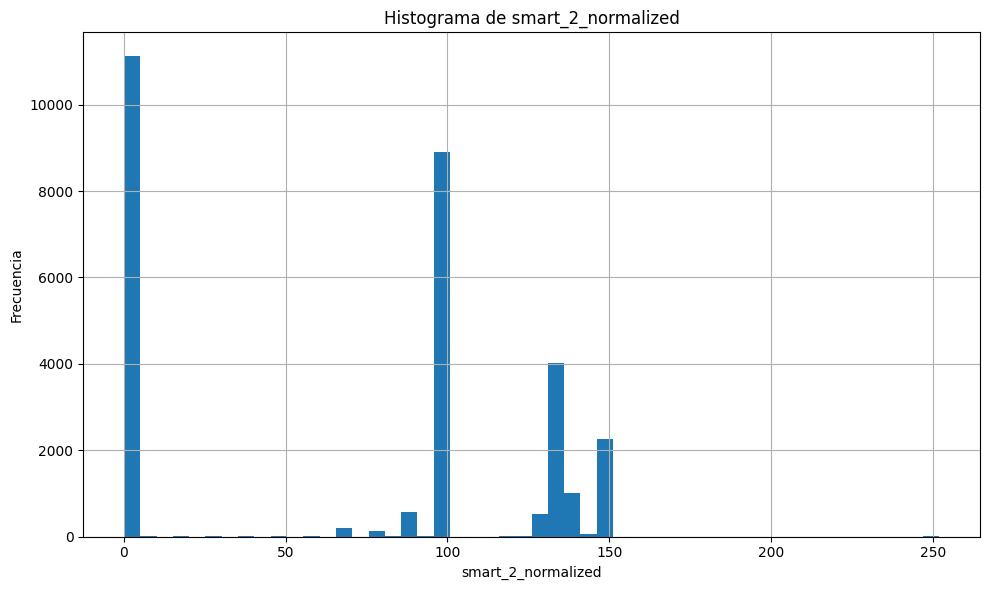

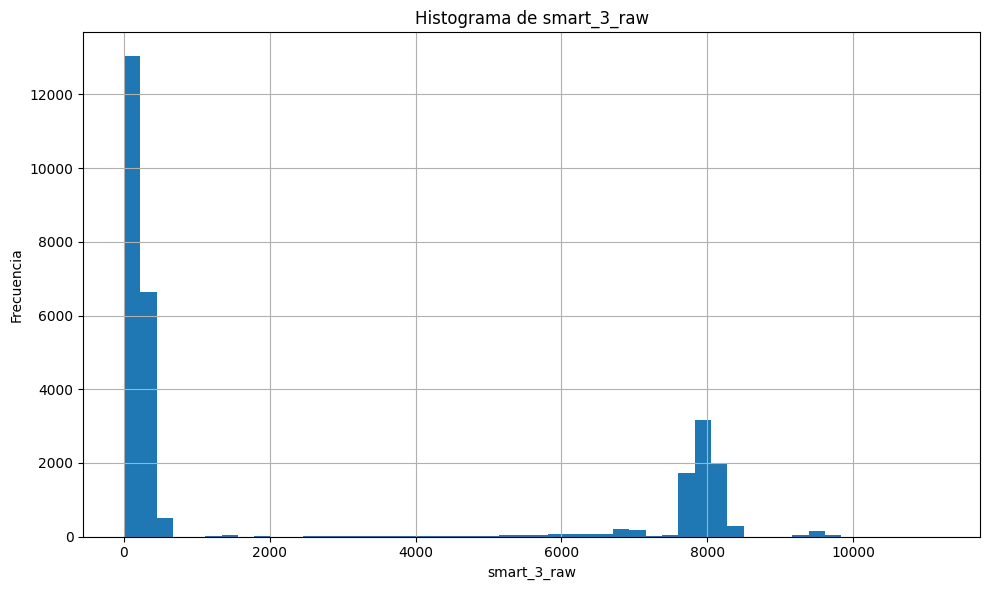

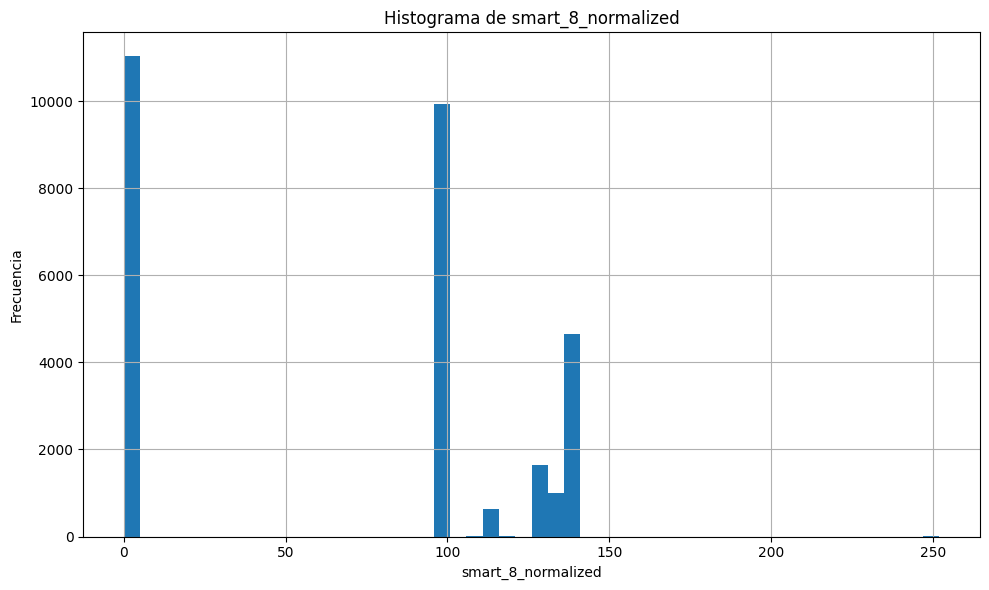

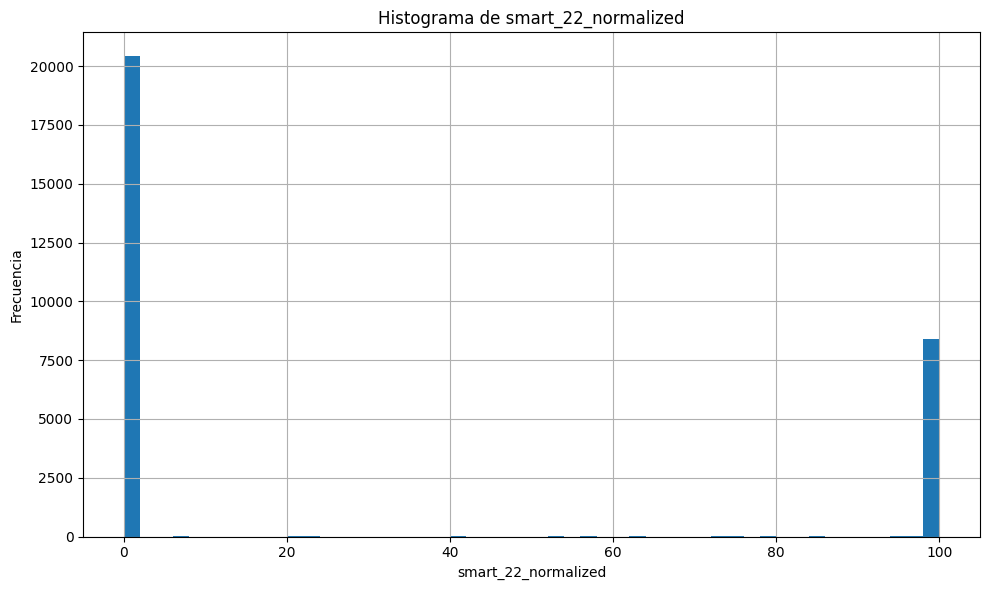

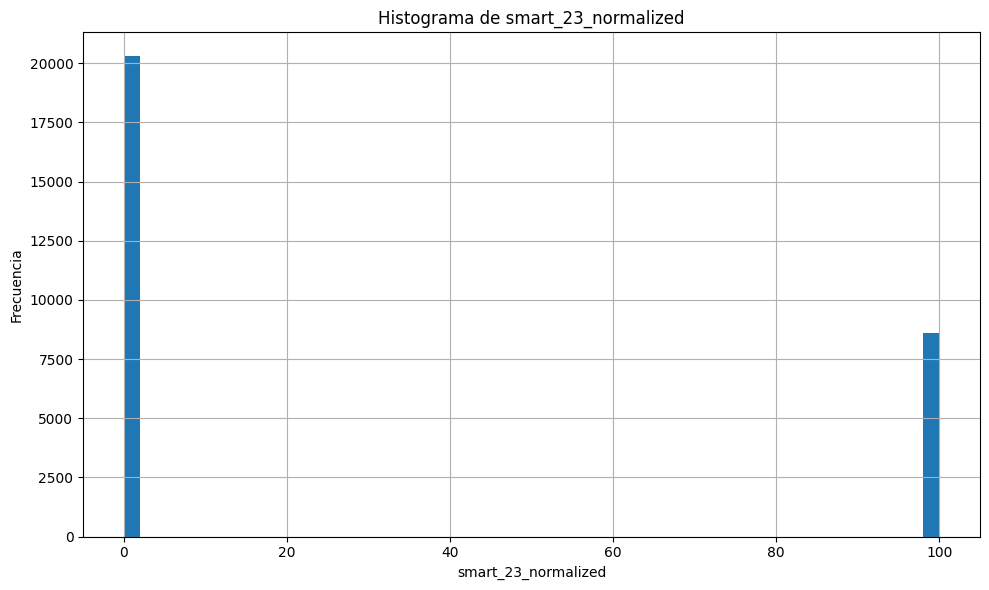

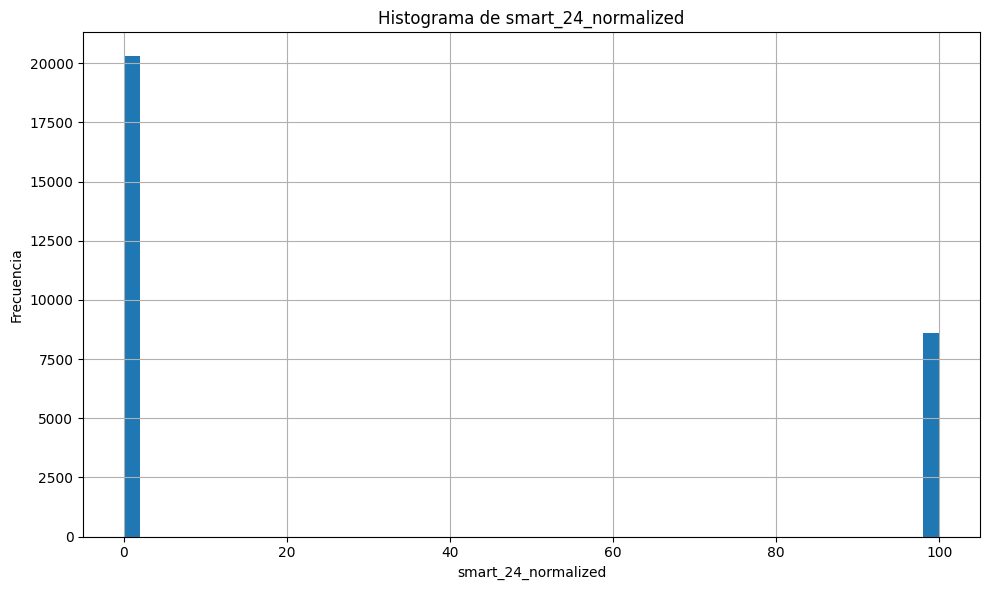

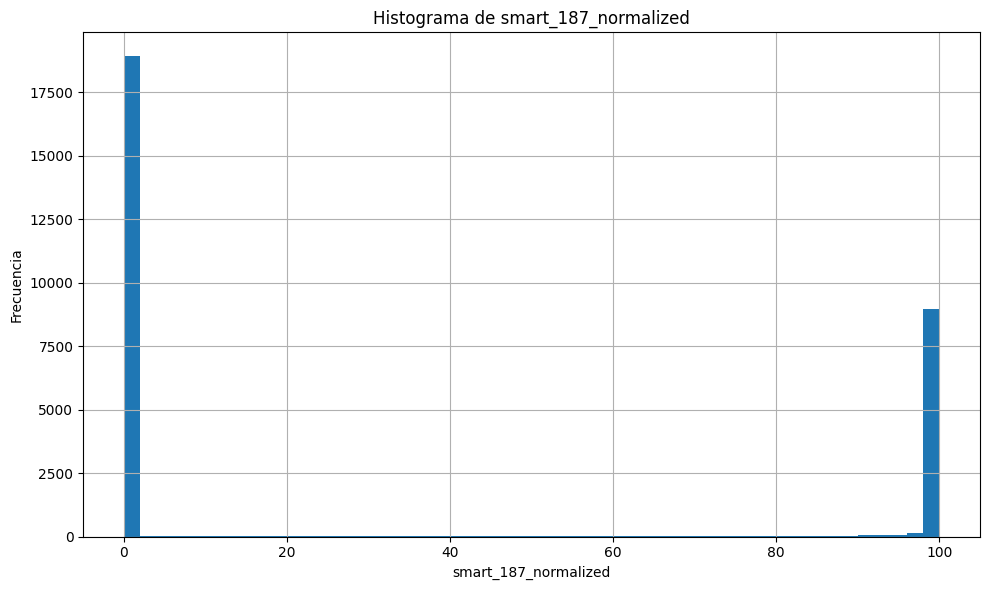

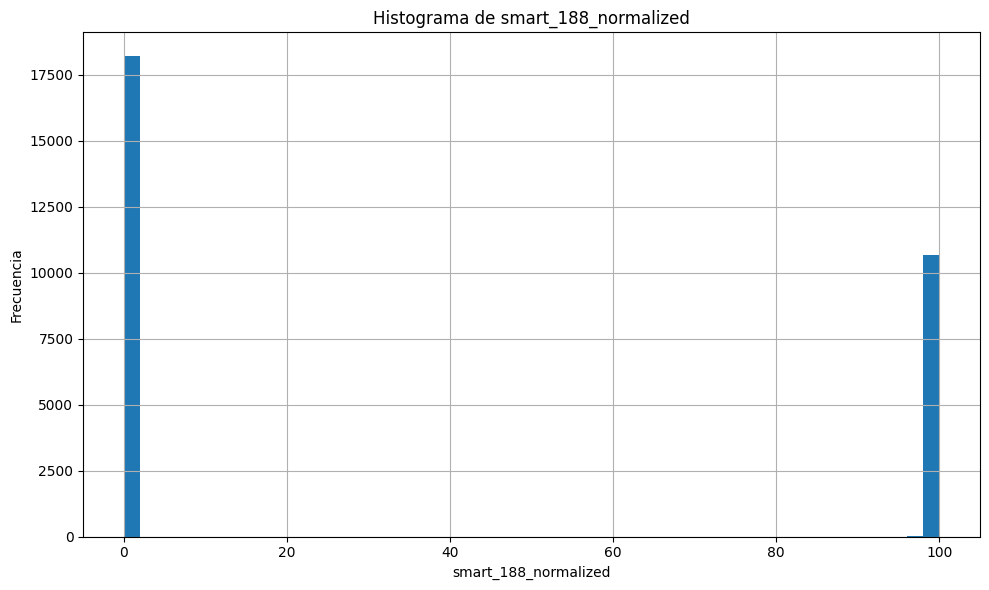

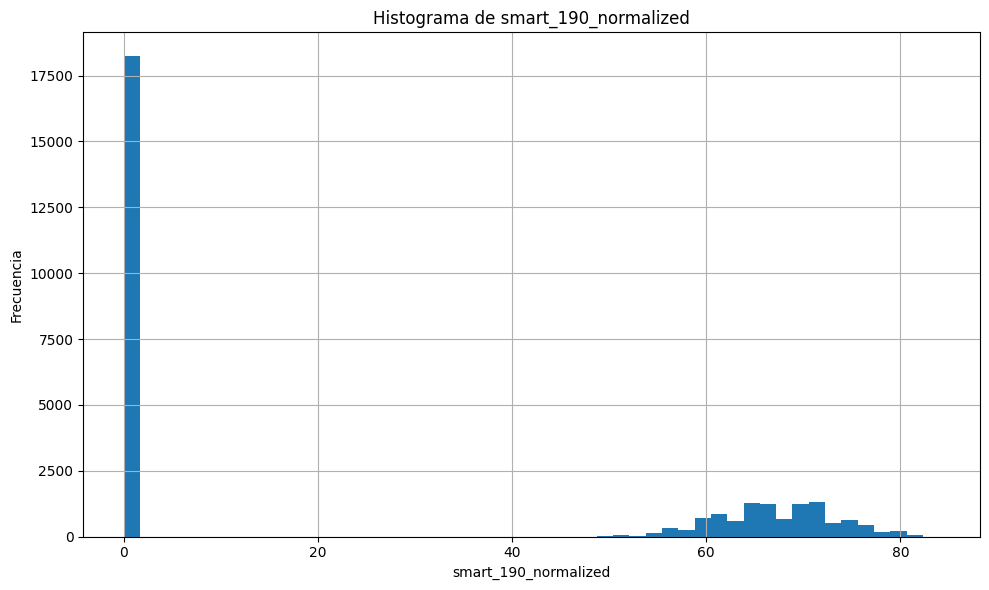

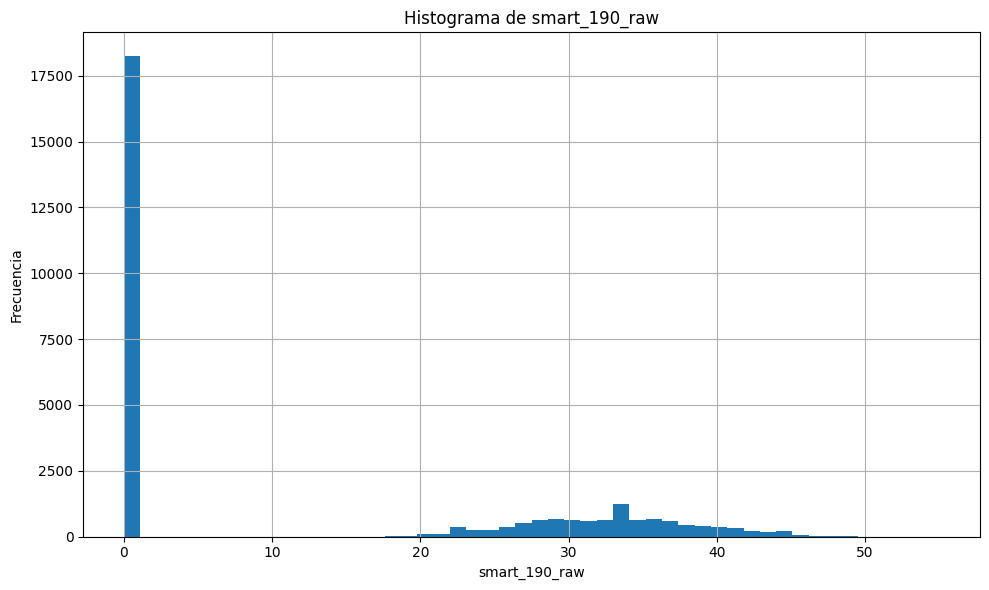

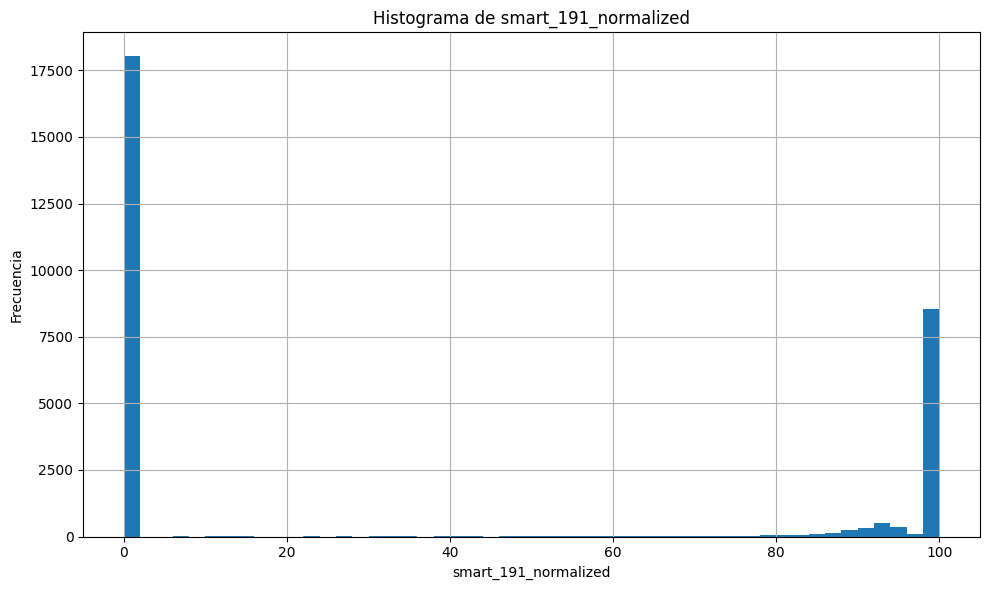

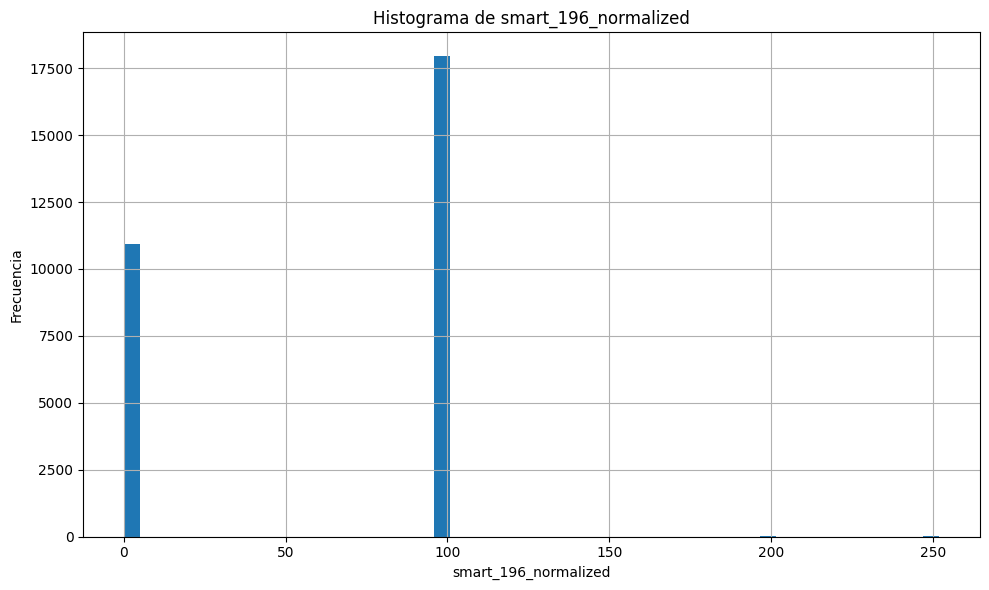

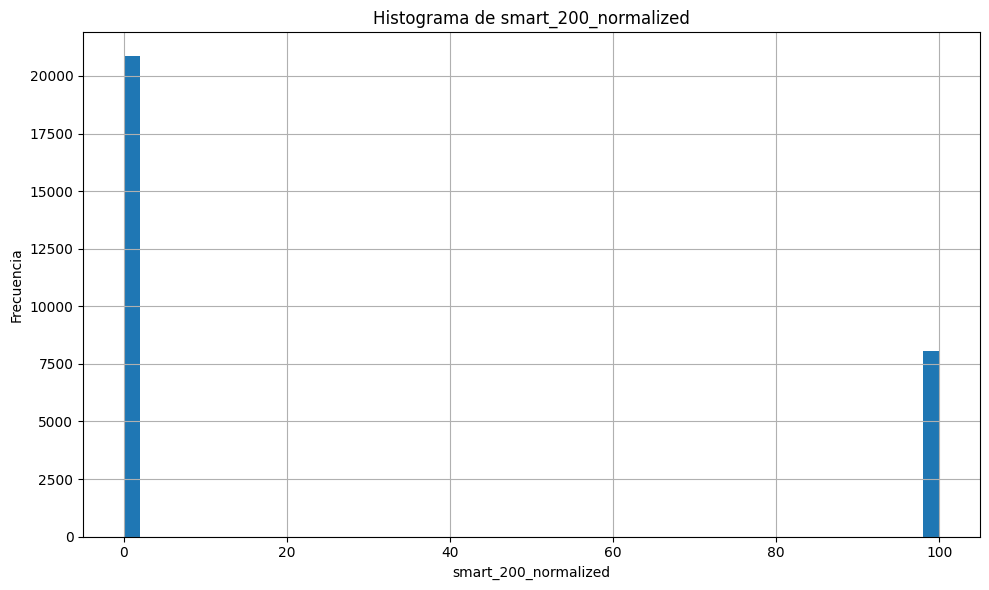

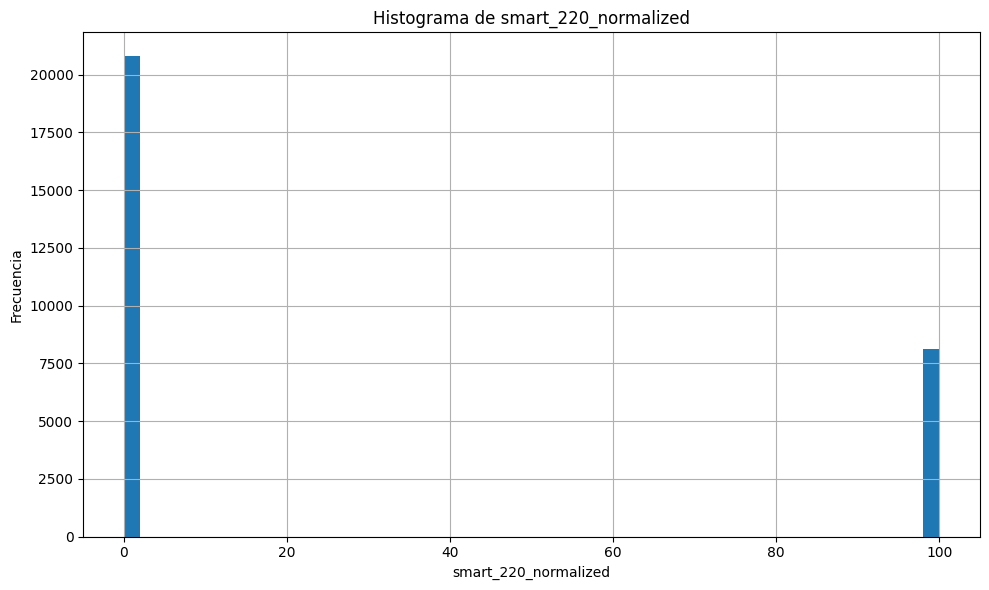

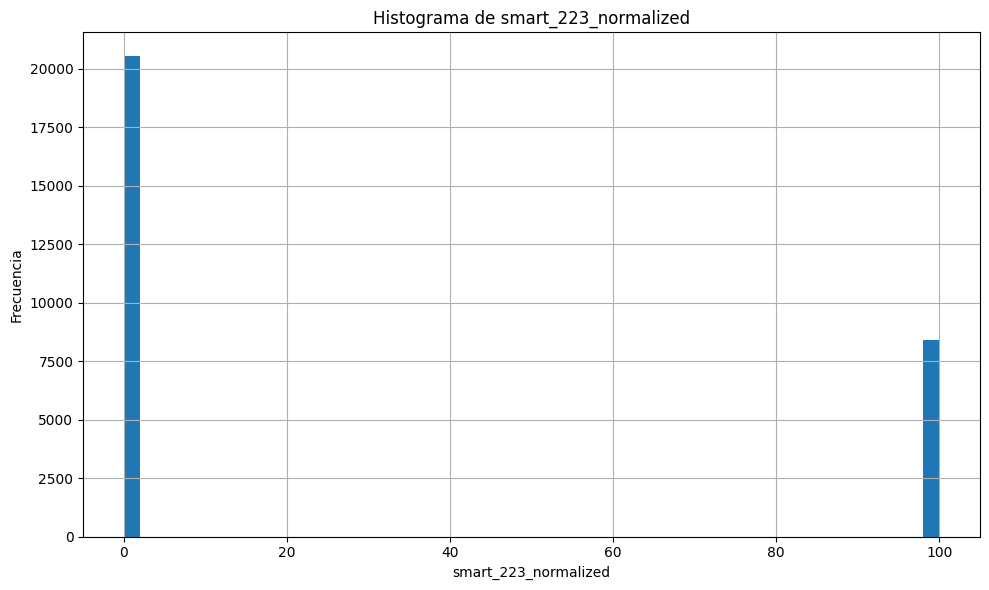

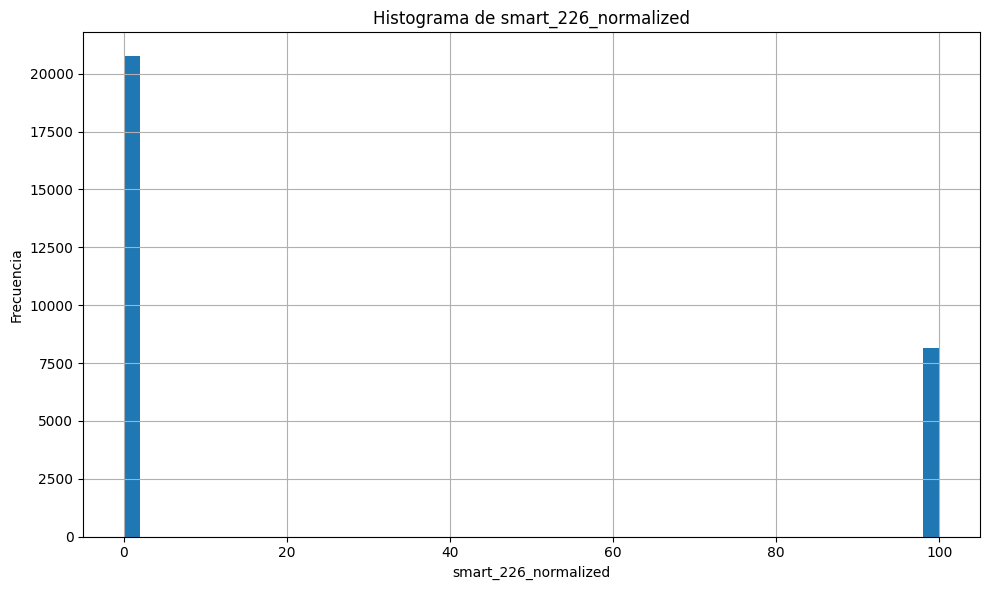

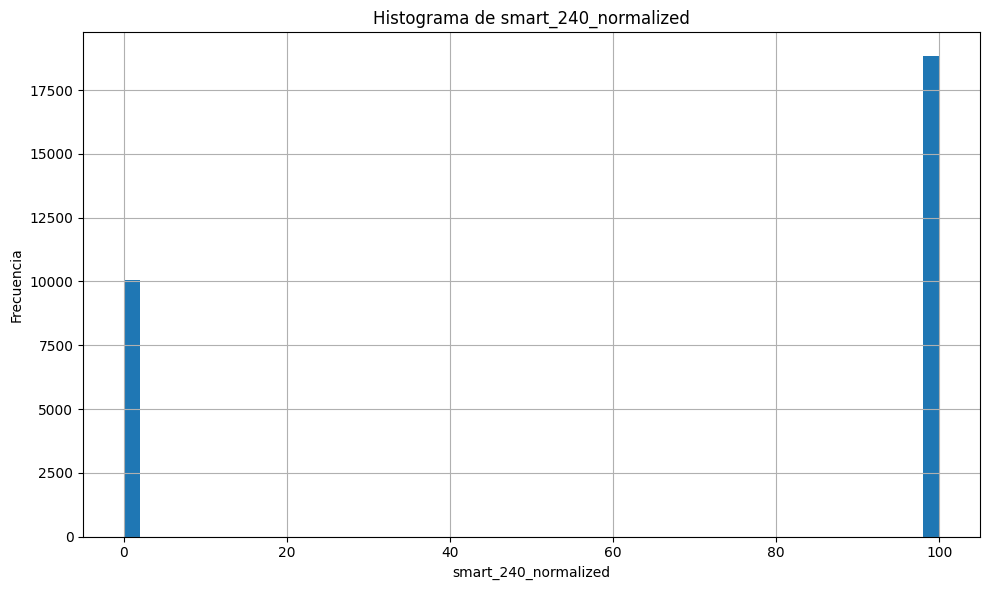

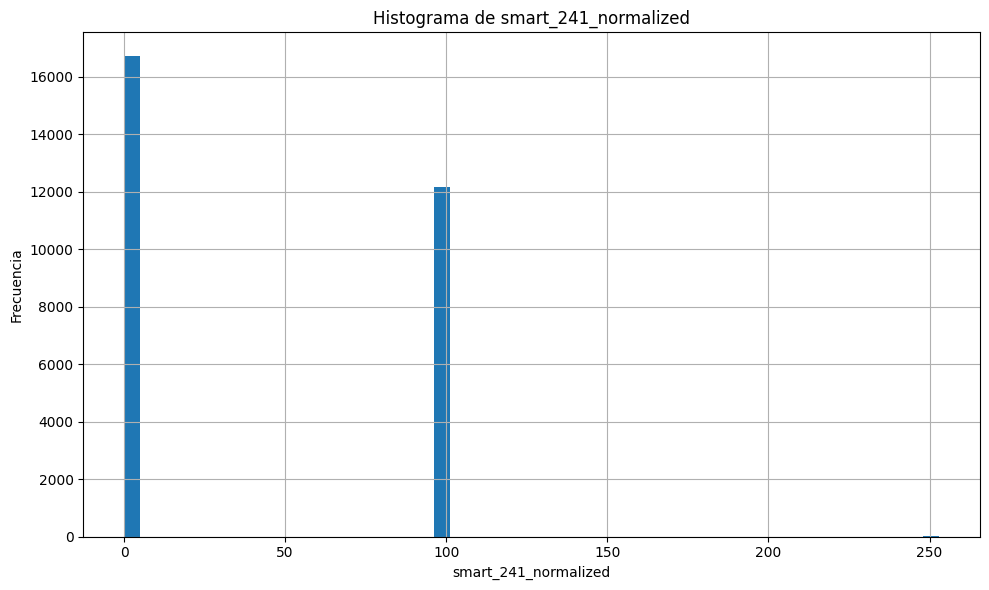

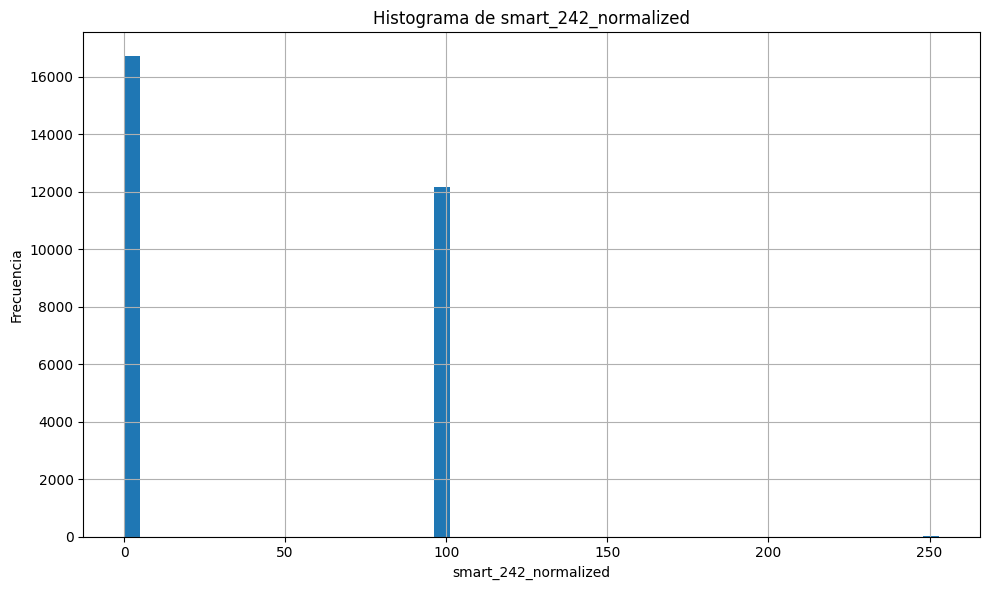

In [17]:
df_smart = df.iloc[:, 5:]
kurtosis_columns = [col for col in df_smart.columns if df_smart[col].kurtosis() < -1.0]
print(f"Columnas con kurtosis menor a -1.0: {kurtosis_columns}")
# Plot the column with kurtosis less than -1.0
for col in kurtosis_columns:
    plt.figure(figsize=(10, 6))
    df[col].dropna().hist(bins=50)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.savefig(f'../reports/figures/histogramas/{col}_histograma.png')
    plt.tight_layout()
    plt.show()
    plt.close()


#### Analizamos en búsqueda de datos atípicos:

Con el IQR vemos que columnas tienen anomalías y las guardamos en un diccionario

In [18]:
# Calcular el rango intercuartílico (IQR) para las columnas 6 en adelante
iqr_values = {}
outliers_dict = {}
no_kurtosis_df = df.drop(columns=kurtosis_columns)
for column in no_kurtosis_df.columns[5:]:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    iqr_values[column] = IQR
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    print(f"Outliers in column {column}: {outliers.shape[0]}")
    if not outliers.empty:
        outliers_dict[column] = outliers

Outliers in column smart_1_normalized: 406
Outliers in column smart_1_raw: 2227
Outliers in column smart_2_raw: 29
Outliers in column smart_3_normalized: 2670
Outliers in column smart_4_normalized: 365
Outliers in column smart_4_raw: 1654
Outliers in column smart_5_normalized: 1191
Outliers in column smart_5_raw: 3781
Outliers in column smart_7_normalized: 624
Outliers in column smart_7_raw: 2706
Outliers in column smart_8_raw: 638
Outliers in column smart_9_normalized: 0
Outliers in column smart_9_raw: 6
Outliers in column smart_10_normalized: 359
Outliers in column smart_10_raw: 0
Outliers in column smart_11_normalized: 17
Outliers in column smart_11_raw: 10
Outliers in column smart_12_normalized: 97
Outliers in column smart_12_raw: 1587
Outliers in column smart_13_normalized: 3
Outliers in column smart_13_raw: 0
Outliers in column smart_15_normalized: 0
Outliers in column smart_15_raw: 0
Outliers in column smart_16_normalized: 152
Outliers in column smart_16_raw: 152
Outliers in col

Creamos el diccionario para sustituir los valores nulos

In [19]:
valores = {}
for column in df.columns[5:]:
    if column not in kurtosis_columns:
        if column in outliers:
            valores[column] = df[column].median()
        else:
            valores[column] = df[column].mean()

print(valores)

{'smart_1_normalized': np.float64(100.0), 'smart_1_raw': np.float64(0.0), 'smart_2_raw': np.float64(0.0), 'smart_3_normalized': np.float64(97.0), 'smart_4_normalized': np.float64(100.0), 'smart_4_raw': np.float64(10.0), 'smart_5_normalized': np.float64(100.0), 'smart_5_raw': np.float64(0.0), 'smart_7_normalized': np.float64(100.0), 'smart_7_raw': np.float64(0.0), 'smart_8_raw': np.float64(0.0), 'smart_9_normalized': np.float64(71.0), 'smart_9_raw': np.float64(29366.0), 'smart_10_normalized': np.float64(100.0), 'smart_10_raw': np.float64(0.0), 'smart_11_normalized': np.float64(0.0), 'smart_11_raw': np.float64(0.0), 'smart_12_normalized': np.float64(100.0), 'smart_12_raw': np.float64(10.0), 'smart_13_normalized': np.float64(0.0), 'smart_13_raw': np.float64(0.0), 'smart_15_normalized': np.float64(0.0), 'smart_15_raw': np.float64(0.0), 'smart_16_normalized': np.float64(0.0), 'smart_16_raw': np.float64(0.0), 'smart_17_normalized': np.float64(0.0), 'smart_17_raw': np.float64(0.0), 'smart_18_

In [20]:
df=df.fillna(valores)
num_columns_with_nan = df.isna().any().sum()
print(f"Number of columns with NaN values: {num_columns_with_nan}")

Number of columns with NaN values: 0


In [21]:
aleatorio=RandomSampleImputer()
for column in kurtosis_columns:
    df[column]=aleatorio.fit_transform(df[[column]])
num_columns_with_nan = df.isna().any().sum()
print(f"Number of columns with NaN values: {num_columns_with_nan}")

Number of columns with NaN values: 0


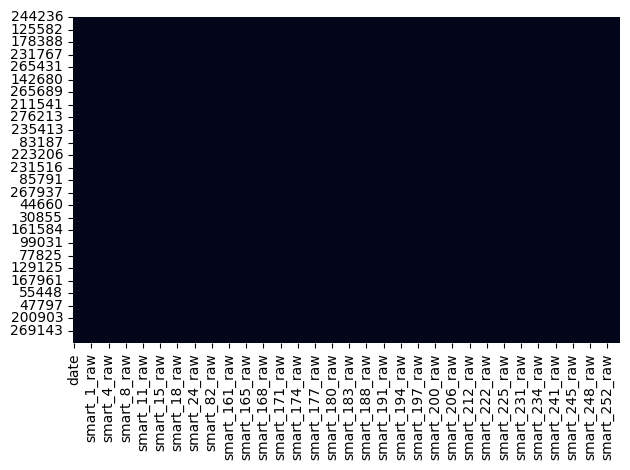

In [22]:
sns.heatmap(df.isnull(), cbar=False)
plt.tight_layout()  # Adjust the layout to ensure nothing is cut off
plt.show()
plt.close()

### Codificación de variables categóricas
-------------
[Codificación de variables categóricas](../references/codificacion_var_categoricas.pdf)

Variables que convertiremos a una variable categórica:
- model: Se va a dividir dos variables: Empresa y modelo.
- capacity_bytes: los separaremos en distintas categorías dependiendo de la cantidad de almacenamiento


In [23]:
# Calcular la frecuencia de cada modelo
model_freq = df['model'].value_counts()

# Crear un diccionario para mapear cada modelo a su frecuencia
model_freq_dict = model_freq.to_dict()

# Crear una nueva columna categórica basada en la frecuencia de uso
df['model_freq'] = df['model'].map(model_freq_dict)

# Convertir la nueva columna a tipo categórico
df['model_freq'] = pd.cut(df['model_freq'], bins=[0, 10, 100, 1000, 10000, float('inf')],
                          labels=['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto'])

print(df[['model', 'model_freq']].head())

                      model model_freq
244236  TOSHIBA MG08ACA16TA       Alto
299107  WDC WUH722222ALE6L4       Alto
106180  WDC WUH721414ALE6L4      Medio
78820         ST16000NM001G       Alto
177056  TOSHIBA MG07ACA14TA       Alto


C:\Users\Green\AppData\Local\Temp\ipykernel_13368\212644200.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['model_freq'] = df['model'].map(model_freq_dict)


Se dividen en marca y modelo

In [24]:
import re

def extract_brand(model):
    match = re.match(r'^[A-Za-z]+', model)
    return match.group(0) if match else None

df['brand'] = df['model'].apply(extract_brand)
print(df['brand'].drop_duplicates())

244236     TOSHIBA
299107         WDC
78820           ST
25506         HGST
220229    DELLBOSS
186278          CT
140430     Seagate
142865     MTFDDAV
194900          WD
208243         WUH
11454       Micron
Name: brand, dtype: object


C:\Users\Green\AppData\Local\Temp\ipykernel_13368\741369294.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['brand'] = df['model'].apply(extract_brand)


In [25]:
print(df.head())

              date serial_number                model  capacity_bytes  \
244236  2025-01-01  8180A0ZCFVKG  TOSHIBA MG08ACA16TA     -2147483648   
299107  2025-01-01      1PGY8TJY  WDC WUH722222ALE6L4     -2147483648   
106180  2025-01-01      QBGUP2JT  WDC WUH721414ALE6L4     -1073741824   
78820   2025-01-01      ZL2P83JJ        ST16000NM001G     -2147483648   
177056  2025-01-01  61A0A0NBF97G  TOSHIBA MG07ACA14TA     -1073741824   

        failure  smart_1_normalized  smart_1_raw  smart_2_normalized  \
244236    False               100.0          0.0               100.0   
299107    False               100.0          0.0               148.0   
106180    False               100.0          0.0               138.0   
78820     False                84.0  237326944.0                 0.0   
177056    False               100.0          0.0               100.0   

        smart_2_raw  smart_3_normalized  ...  smart_251_normalized  \
244236          0.0               100.0  ...              

Ahora se aplica OH a la marca y la frecuencia del modelo

In [26]:
df = pd.get_dummies(df, columns=['brand', 'model_freq'])
print(df.head())

              date serial_number                model  capacity_bytes  \
244236  2025-01-01  8180A0ZCFVKG  TOSHIBA MG08ACA16TA     -2147483648   
299107  2025-01-01      1PGY8TJY  WDC WUH722222ALE6L4     -2147483648   
106180  2025-01-01      QBGUP2JT  WDC WUH721414ALE6L4     -1073741824   
78820   2025-01-01      ZL2P83JJ        ST16000NM001G     -2147483648   
177056  2025-01-01  61A0A0NBF97G  TOSHIBA MG07ACA14TA     -1073741824   

        failure  smart_1_normalized  smart_1_raw  smart_2_normalized  \
244236    False               100.0          0.0               100.0   
299107    False               100.0          0.0               148.0   
106180    False               100.0          0.0               138.0   
78820     False                84.0  237326944.0                 0.0   
177056    False               100.0          0.0               100.0   

        smart_2_raw  smart_3_normalized  ...  brand_Seagate  brand_TOSHIBA  \
244236          0.0               100.0  ...      

#### Convirtiendo a categórica ordinal capacity_bytes:

In [27]:
print(df['capacity_bytes'].unique())

[-2147483648 -1073741824           0    39149568 -2122489856  -999489536
  1891655680   951246848  -460759040  1105813504          -1  -932356096
        -512]


In [42]:
# Replace -1 in 'capacity_bytes' with the correct value from the same serial_number

# First, find serial_numbers with more than one unique capacity (including -1)
mask_minus1 = df['capacity_bytes'] == '-1'
serials_with_minus1 = df.loc[mask_minus1, 'serial_number'].unique()

# For each affected serial_number, replace -1 with the other value
for serial in tqdm(serials_with_minus1, desc="Replacing -1 in capacity_bytes"):
    # Get all unique non -1 capacities for this serial_number
    capacities = df.loc[(df['serial_number'] == serial) & (df['capacity_bytes'] != '-1'), 'capacity_bytes'].unique()
    if len(capacities) == 1:
        correct_capacity = capacities[0]
        df.loc[(df['serial_number'] == serial) & (df['capacity_bytes'] == '-1'), 'capacity_bytes'] = correct_capacity

print("Replaced -1 values in 'capacity_bytes' where possible.")

Replacing -1 in capacity_bytes: 0it [00:00, ?it/s]

Replaced -1 values in 'capacity_bytes' where possible.


In [43]:
print(df['capacity_bytes'].unique())

[-2147483648 -1073741824           0    39149568 -2122489856  -999489536
  1891655680   951246848  -460759040  1105813504          -1  -932356096
        -512]


In [30]:
Var=df['capacity_bytes']                      # Variable categórica ordinal
n=Var.nunique()                     # Cardinalidad
lim_inf=(n-1)//2 if n%2!=0 else n-1 # Abs del límite inferior
step=1 if n%2!=0 else 2             # Intervalo
X=range(-lim_inf,lim_inf+1,step)
list(X)

[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]

In [31]:
beta0=0
beta1=1 # beta1>0  ->  codificación creciente. beta1<0  ->  codificación decreciente
y=[beta0+beta1*x for x in X]
y

[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6]

In [32]:
# Asociamos estos valores a las categorías ordenadas de 'Var'
# Var.unique()
Var_ord = np.sort(Var.unique())
Var_ord

array([-2147483648, -2122489856, -1073741824,  -999489536,  -932356096,
        -460759040,        -512,          -1,           0,    39149568,
         951246848,  1105813504,  1891655680], dtype=int32)

In [33]:
map_lin_CB={categoria:codificacion for categoria,codificacion in zip(Var_ord,y)}
map_lin_CB

{np.int32(-2147483648): -6,
 np.int32(-2122489856): -5,
 np.int32(-1073741824): -4,
 np.int32(-999489536): -3,
 np.int32(-932356096): -2,
 np.int32(-460759040): -1,
 np.int32(-512): 0,
 np.int32(-1): 1,
 np.int32(0): 2,
 np.int32(39149568): 3,
 np.int32(951246848): 4,
 np.int32(1105813504): 5,
 np.int32(1891655680): 6}

In [34]:
df['Lin_capacity_bytes']=df['capacity_bytes'].map(map_lin_CB)

df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,brand_TOSHIBA,brand_WD,brand_WDC,brand_WUH,model_freq_Muy Bajo,model_freq_Bajo,model_freq_Medio,model_freq_Alto,model_freq_Muy Alto,Lin_capacity_bytes
244236,2025-01-01,8180A0ZCFVKG,TOSHIBA MG08ACA16TA,-2147483648,False,100.0,0.0,100.0,0.0,100.0,...,True,False,False,False,False,False,False,True,False,-6
299107,2025-01-01,1PGY8TJY,WDC WUH722222ALE6L4,-2147483648,False,100.0,0.0,148.0,48.0,84.0,...,False,False,True,False,False,False,False,True,False,-6
106180,2025-01-01,QBGUP2JT,WDC WUH721414ALE6L4,-1073741824,False,100.0,0.0,138.0,96.0,95.0,...,False,False,True,False,False,False,True,False,False,-4
78820,2025-01-01,ZL2P83JJ,ST16000NM001G,-2147483648,False,84.0,237326944.0,0.0,0.0,93.0,...,False,False,False,False,False,False,False,True,False,-6
177056,2025-01-01,61A0A0NBF97G,TOSHIBA MG07ACA14TA,-1073741824,False,100.0,0.0,100.0,0.0,100.0,...,True,False,False,False,False,False,False,True,False,-4


## Step 2: Load the data to train the models

In [35]:
min_sequence_length = days_to_train + days_to_predict
print(f'Using device: {device}')


Using device: cuda


In [36]:

print("🔄 Loading and splitting data to prevent data leakage...")

train_loader, test_loader = smart.load_data(root=lstm_data_path,
                                        train_ratio=0.8, 
                                        min_sequence_length=min_sequence_length,
                                        input_len=days_to_train,
                                        label_len=days_to_predict,
                                        normalized_rows=normalized_rows,
                                        raw_rows=raw_rows,
                                        verbose=verbose)


🔄 Loading and splitting data to prevent data leakage...
[DriveDataLoader] Found 0 subfolders in ../data/data_test.


Loading CSV files:  17%|█▋        | 1/6 [00:04<00:21,  4.30s/it]

Loaded ../data/data_test\2024-10-01.csv with shape (292679, 189)


Loading CSV files:  33%|███▎      | 2/6 [00:08<00:17,  4.29s/it]

Loaded ../data/data_test\2024-10-02.csv with shape (292648, 189)


Loading CSV files:  50%|█████     | 3/6 [00:13<00:13,  4.64s/it]

Loaded ../data/data_test\2024-10-03.csv with shape (292662, 189)


Loading CSV files:  67%|██████▋   | 4/6 [00:17<00:08,  4.48s/it]

Loaded ../data/data_test\2024-10-04.csv with shape (292694, 189)


Loading CSV files:  83%|████████▎ | 5/6 [00:23<00:05,  5.02s/it]

Loaded ../data/data_test\2024-10-05.csv with shape (292693, 189)


Loading CSV files: 100%|██████████| 6/6 [00:29<00:00,  4.98s/it]

Loaded ../data/data_test\2024-10-06.csv with shape (292683, 189)
[DriveDataLoader] Columns in data: ['date', 'serial_number', 'failure', 'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized', 'smart_2_raw', 'smart_3_normalized', 'smart_3_raw', 'smart_4_normalized', 'smart_4_raw', 'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized', 'smart_7_raw', 'smart_8_normalized', 'smart_8_raw', 'smart_9_normalized', 'smart_9_raw', 'smart_10_normalized', 'smart_10_raw', 'smart_11_normalized', 'smart_11_raw', 'smart_12_normalized', 'smart_12_raw', 'smart_13_normalized', 'smart_13_raw', 'smart_15_normalized', 'smart_15_raw', 'smart_16_normalized', 'smart_16_raw', 'smart_17_normalized', 'smart_17_raw', 'smart_18_normalized', 'smart_18_raw', 'smart_22_normalized', 'smart_22_raw', 'smart_23_normalized', 'smart_23_raw', 'smart_24_normalized', 'smart_24_raw', 'smart_27_normalized', 'smart_27_raw', 'smart_71_normalized', 'smart_71_raw', 'smart_82_normalized', 'smart_82_raw', 'smart_90_normalized'

[DriveDataLoader] Loaded 1756059 rows from all CSV files. DataFrame shape: (1756059, 189)
[DriveDataLoader] Found 292766 unique drives.
[DriveDataLoader] Filtering drives with minimum 5 days...
[DriveDataLoader] Valid drives (>= 5 days): 292624
[DriveDataLoader] Invalid drives (< 5 days): 142
[DriveDataLoader] Sequence length distribution of invalid drives:
[DriveDataLoader]   {1: np.int64(19), 2: np.int64(28), 3: np.int64(54), 4: np.int64(41)}
[DriveDataLoader] Split: 234099 drives for training, 58525 drives for testing.
[DriveDataLoader] Train ratio: 80.00%
[DriveDataLoader] Final dataset: 1755658 rows from 292624 valid drives.
[DriveDataLoader] Sample TRAIN drive 2GG3UKHD: 6 rows, dates 2024-10-01 to 2024-10-06
[DriveDataLoader] Sample TEST drive ZL2D6FJZ: 6 rows, dates 2024-10-01 to 2024-10-06
[DriveDataLoader] ✅ Verified: No drive overlap between train and test sets.

[DriveDataLoader] 📊 Sample drive verification:
[DriveDataLoader] 🚂 TRAIN sample - Drive 2GG3UKHD:
[DriveDataLoader

In [48]:
best_params, best_loss = smart.grid_search_lstm(
    root=lstm_data_path,
    train_ratio=0.8,
    min_sequence_length=min_sequence_length,
    days_to_train=days_to_train,
    days_to_predict=days_to_predict,
    normalized_rows=[1, 3, 5, 7, 9, 187, 189, 190, 195, 197],
    raw_rows=[5, 197],
    verbose=verbose,
    num_features=num_features,
    device=device,
    param_grid=None,
    max_epochs=num_epochs
)

TypeError: grid_search_lstm() missing 2 required positional arguments: 'input_len' and 'label_len'

In [ ]:
if best_params is not None:
    n_neurons = best_params['n_neurons']
    learning_rate = best_params['learning_rate']
else:
    raise RuntimeError("Grid search did not return any valid parameters. Please check your data and parameter grid.")


# Step 3: Train the LSTM model

In [ ]:
# Check if trained model exists
model_path = 'models/LSTM/lstm_model.pth'

model, model_exists = smart.train_model(features = num_features,
            n_neurons = n_neurons,
            model_path = model_path,
            days_to_predict = days_to_predict,
            days_to_train = days_to_train,
            train_loader = train_loader,
            test_loader = test_loader,
            test_existing = False,
            learning_rate = learning_rate,
            num_epochs = num_epochs)


shape: (torch.Size([3, 3, 10]), torch.Size([3, 2, 10]))
No saved model found. Training from scratch...


Training Progress: 100%|██████████| 1/1 [17:11<00:00, 1031.07s/it]


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 11684835686301358080.000000
Epoch 1/1 - Train Loss: 66149996231036805120.000000, Val Loss: 11684835686301358080.000000
✅ Final loss curve saved to models/LSTM\final_loss.png


## Step 4: Generate predictions 

In [ ]:
# Generate predictions on test set
model.eval()
test_predictions = []
test_targets = []

print("Generating final predictions...")
with torch.no_grad():
    for test_data, test_labels in tqdm(test_loader, desc="Generating predictions"):
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        predictions = model(test_data)
        test_predictions.append(predictions.cpu().numpy())
        test_targets.append(test_labels.cpu().numpy())

# Concatenate all predictions and targets
test_predictions = np.concatenate(test_predictions, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

Generating final predictions...


Generating predictions: 100%|██████████| 19509/19509 [01:37<00:00, 200.74it/s]


# Step 5: Plot the results

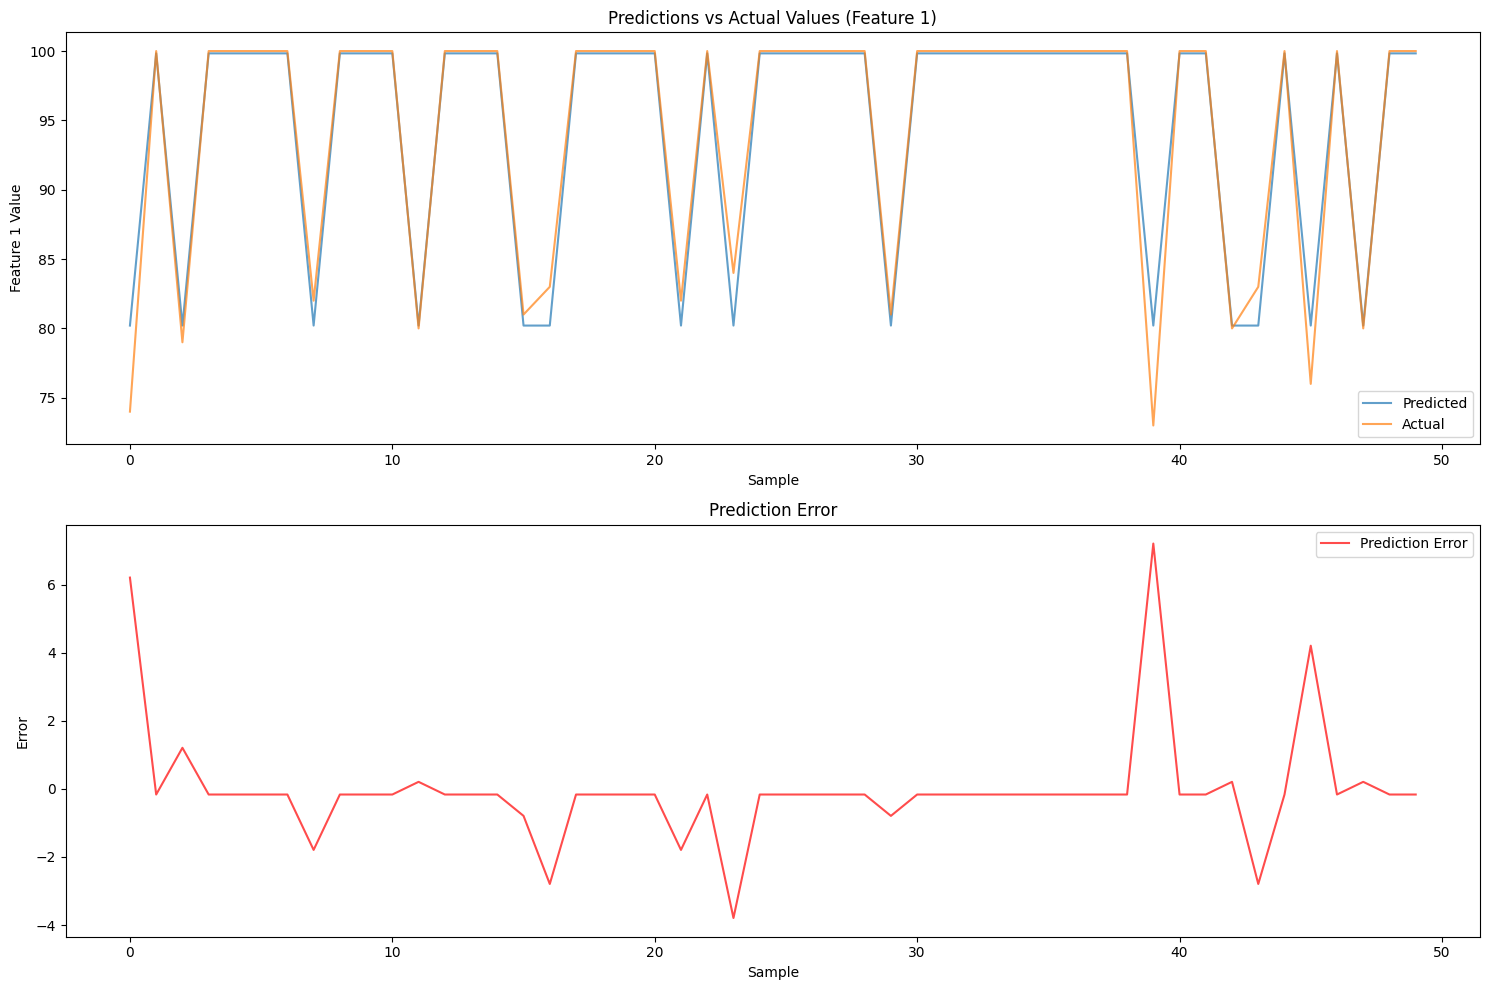

In [ ]:
# Plot predictions vs actual values for the first feature
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot first few samples for visualization
num_samples_to_plot = min(50, len(test_predictions))
x = np.arange(num_samples_to_plot)

ax1.plot(x, test_predictions[:num_samples_to_plot, 0, 0], label='Predicted', alpha=0.7)
ax1.plot(x, test_targets[:num_samples_to_plot, 0, 0], label='Actual', alpha=0.7)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Feature 1 Value")
ax1.set_title("Predictions vs Actual Values (Feature 1)")
ax1.legend()

# Plot prediction error
error = test_predictions[:num_samples_to_plot, 0, 0] - test_targets[:num_samples_to_plot, 0, 0]
ax2.plot(x, error, label='Prediction Error', color='red', alpha=0.7)
ax2.set_xlabel("Sample")
ax2.set_ylabel("Error")
ax2.set_title("Prediction Error")
ax2.legend()
plt.tight_layout()

## Step 4: Train and Test the Decision Tree (CT) on Raw Data

We will now train and test the Decision Tree model using the raw SMART data.

### Step 4.1: Load the data to train the Decision Tree model

In [ ]:
data = CT.importdata(ct_data_path, normalized_rows, raw_rows)

# Split dataset and apply SMOTE
X, Y, X_train_res, X_test, y_train_res, y_test = CT.splitdataset(data)

Processing subfolders:  20%|██        | 2/10 [00:07<00:30,  3.78s/it]


KeyboardInterrupt: 

In [ ]:
# Grid search for best hyperparameters (Gini)
print("\nPerforming grid search for Decision Tree (Gini)...")
best_params, best_score = CT.grid_search_decision_tree(X_train_res, y_train_res)
depth = best_params['max_depth']
leaf = best_params['min_samples_leaf']

### Train both decision tree models

In [ ]:
print("\nTraining Decision Tree with Gini criterion...")
clf_gini = CT.train_using_gini(X_train_res, X_test, y_train_res, depth=depth, leaf=leaf)


Training Decision Tree with Gini criterion...


In [ ]:
print("\nTraining Decision Tree with Entropy criterion...")
clf_entropy = CT.train_using_entropy(X_train_res, X_test, y_train_res, depth=depth, leaf=leaf)


Training Decision Tree with Entropy criterion...


### Test models

In [ ]:
print("\n" + "="*50)
print("Results Using Gini Index:")
print("="*50)
y_pred_gini = CT.prediction(X_test, clf_gini)


Results Using Gini Index:
Predicted values:
[False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False  True False False False False False False False  True False
 False False  True False False False False  True False  True False  True
 False  True False False  True False False False False False  True False
 False False False False False False False False False  True False  True
 False False False False False  True False False False False False False
  True False False False  True False False False False False False False
 False False  True  True False False False False False]


In [ ]:
gini_accuracy = CT.cal_accuracy(y_test, y_pred_gini, clf_gini, "gini")

Confusion Matrix:  [[93  2]
 [ 6 16]]
Accuracy :  93.16239316239316
Report :                precision    recall  f1-score   support

       False       0.94      0.98      0.96        95
        True       0.89      0.73      0.80        22

    accuracy                           0.93       117
   macro avg       0.91      0.85      0.88       117
weighted avg       0.93      0.93      0.93       117

FP:  2.0
FN:  6.0
TP:  16.0
TN:  93.0
TPR:  0.7272727272727273
TNR:  0.9789473684210527
PPV:  0.8888888888888888
NPV:  0.9393939393939394
FPR:  0.021052631578947368
FNR:  0.2727272727272727
FDR:  0.1111111111111111
ACC:  0.9316239316239316
❌ New gini model accuracy (0.9316) not better than previous best (0.9316)


In [ ]:
print("\n" + "="*50)
print("Results Using Gini Index:")
print("="*50)
y_pred_gini = CT.prediction(X_test, clf_gini)
gini_accuracy = CT.cal_accuracy(y_test, y_pred_gini, clf_gini, "gini")


Results Using Gini Index:
Predicted values:
[False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False  True False False False False False False False  True False
 False False  True False False False False  True False  True False  True
 False  True False False  True False False False False False  True False
 False False False False False False False False False  True False  True
 False False False False False  True False False False False False False
  True False False False  True False False False False False False False
 False False  True  True False False False False False]
Confusion Matrix:  [[93  2]
 [ 6 16]]
Accuracy :  93.16239316239316
Report :                precision    recall  f1-score   support

       False       0.94      0.98      0.96        95
        True       0.89      0.73      0.80        22



In [ ]:
print("\n" + "="*50)
print("Results Using Entropy:")
print("="*50)
y_pred_entropy = CT.prediction(X_test, clf_entropy)


Results Using Entropy:
Predicted values:
[False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False  True False False False False False False False  True False
 False False  True False False False False  True False  True False  True
 False  True False False  True False False False False False  True False
 False False False False False False False False False  True False  True
 False False False False False  True False False False False False False
  True False False False  True False False False False False False False
 False False  True  True False False False False False]


In [ ]:
CT.cal_accuracy(y_test, y_pred_entropy, clf_entropy, "entropy")

Confusion Matrix:  [[93  2]
 [ 6 16]]
Accuracy :  93.16239316239316
Report :                precision    recall  f1-score   support

       False       0.94      0.98      0.96        95
        True       0.89      0.73      0.80        22

    accuracy                           0.93       117
   macro avg       0.91      0.85      0.88       117
weighted avg       0.93      0.93      0.93       117

FP:  2.0
FN:  6.0
TP:  16.0
TN:  93.0
TPR:  0.7272727272727273
TNR:  0.9789473684210527
PPV:  0.8888888888888888
NPV:  0.9393939393939394
FPR:  0.021052631578947368
FNR:  0.2727272727272727
FDR:  0.1111111111111111
ACC:  0.9316239316239316
❌ New entropy model accuracy (0.9316) not better than previous best (0.9316)


0.9316239316239316

### Save models

In [ ]:
# Directory to store models
dt_model_dir = "models/DT"
os.makedirs(dt_model_dir, exist_ok=True)

# Paths for Gini and Entropy models
gini_model_path = os.path.join(dt_model_dir, "dt_gini.joblib")
entropy_model_path = os.path.join(dt_model_dir, "dt_entropy.joblib")

# Helper function to load accuracy if model exists
def load_existing_accuracy(model_path):
    acc_path = model_path + ".acc"
    if os.path.exists(acc_path):
        with open(acc_path, "r") as f:
            return float(f.read().strip())
    return None

# Save model and accuracy
def save_model_and_accuracy(model, model_path, accuracy):
    joblib.dump(model, model_path)
    with open(model_path + ".acc", "w") as f:
        f.write(str(accuracy))

# Check and save Gini model if better
existing_gini_acc = load_existing_accuracy(gini_model_path)
if existing_gini_acc is None or gini_accuracy > existing_gini_acc:
    save_model_and_accuracy(clf_gini, gini_model_path, gini_accuracy)
    print(f"Saved improved Gini model with accuracy {gini_accuracy:.4f}")

# Check and save Entropy model if better
existing_entropy_acc = load_existing_accuracy(entropy_model_path)
entropy_accuracy = CT.cal_accuracy(y_test, y_pred_entropy, clf_entropy, "entropy")
if existing_entropy_acc is None or entropy_accuracy > existing_entropy_acc:
    save_model_and_accuracy(clf_entropy, entropy_model_path, entropy_accuracy)
    print(f"Saved improved Entropy model with accuracy {entropy_accuracy:.4f}")

Confusion Matrix:  [[93  2]
 [ 6 16]]
Accuracy :  93.16239316239316
Report :                precision    recall  f1-score   support

       False       0.94      0.98      0.96        95
        True       0.89      0.73      0.80        22

    accuracy                           0.93       117
   macro avg       0.91      0.85      0.88       117
weighted avg       0.93      0.93      0.93       117

FP:  2.0
FN:  6.0
TP:  16.0
TN:  93.0
TPR:  0.7272727272727273
TNR:  0.9789473684210527
PPV:  0.8888888888888888
NPV:  0.9393939393939394
FPR:  0.021052631578947368
FNR:  0.2727272727272727
FDR:  0.1111111111111111
ACC:  0.9316239316239316
❌ New entropy model accuracy (0.9316) not better than previous best (0.9316)


### Visualize the results

In [ ]:
smart_features = [f'smart_{i:03}' for i in range(1, 255)]

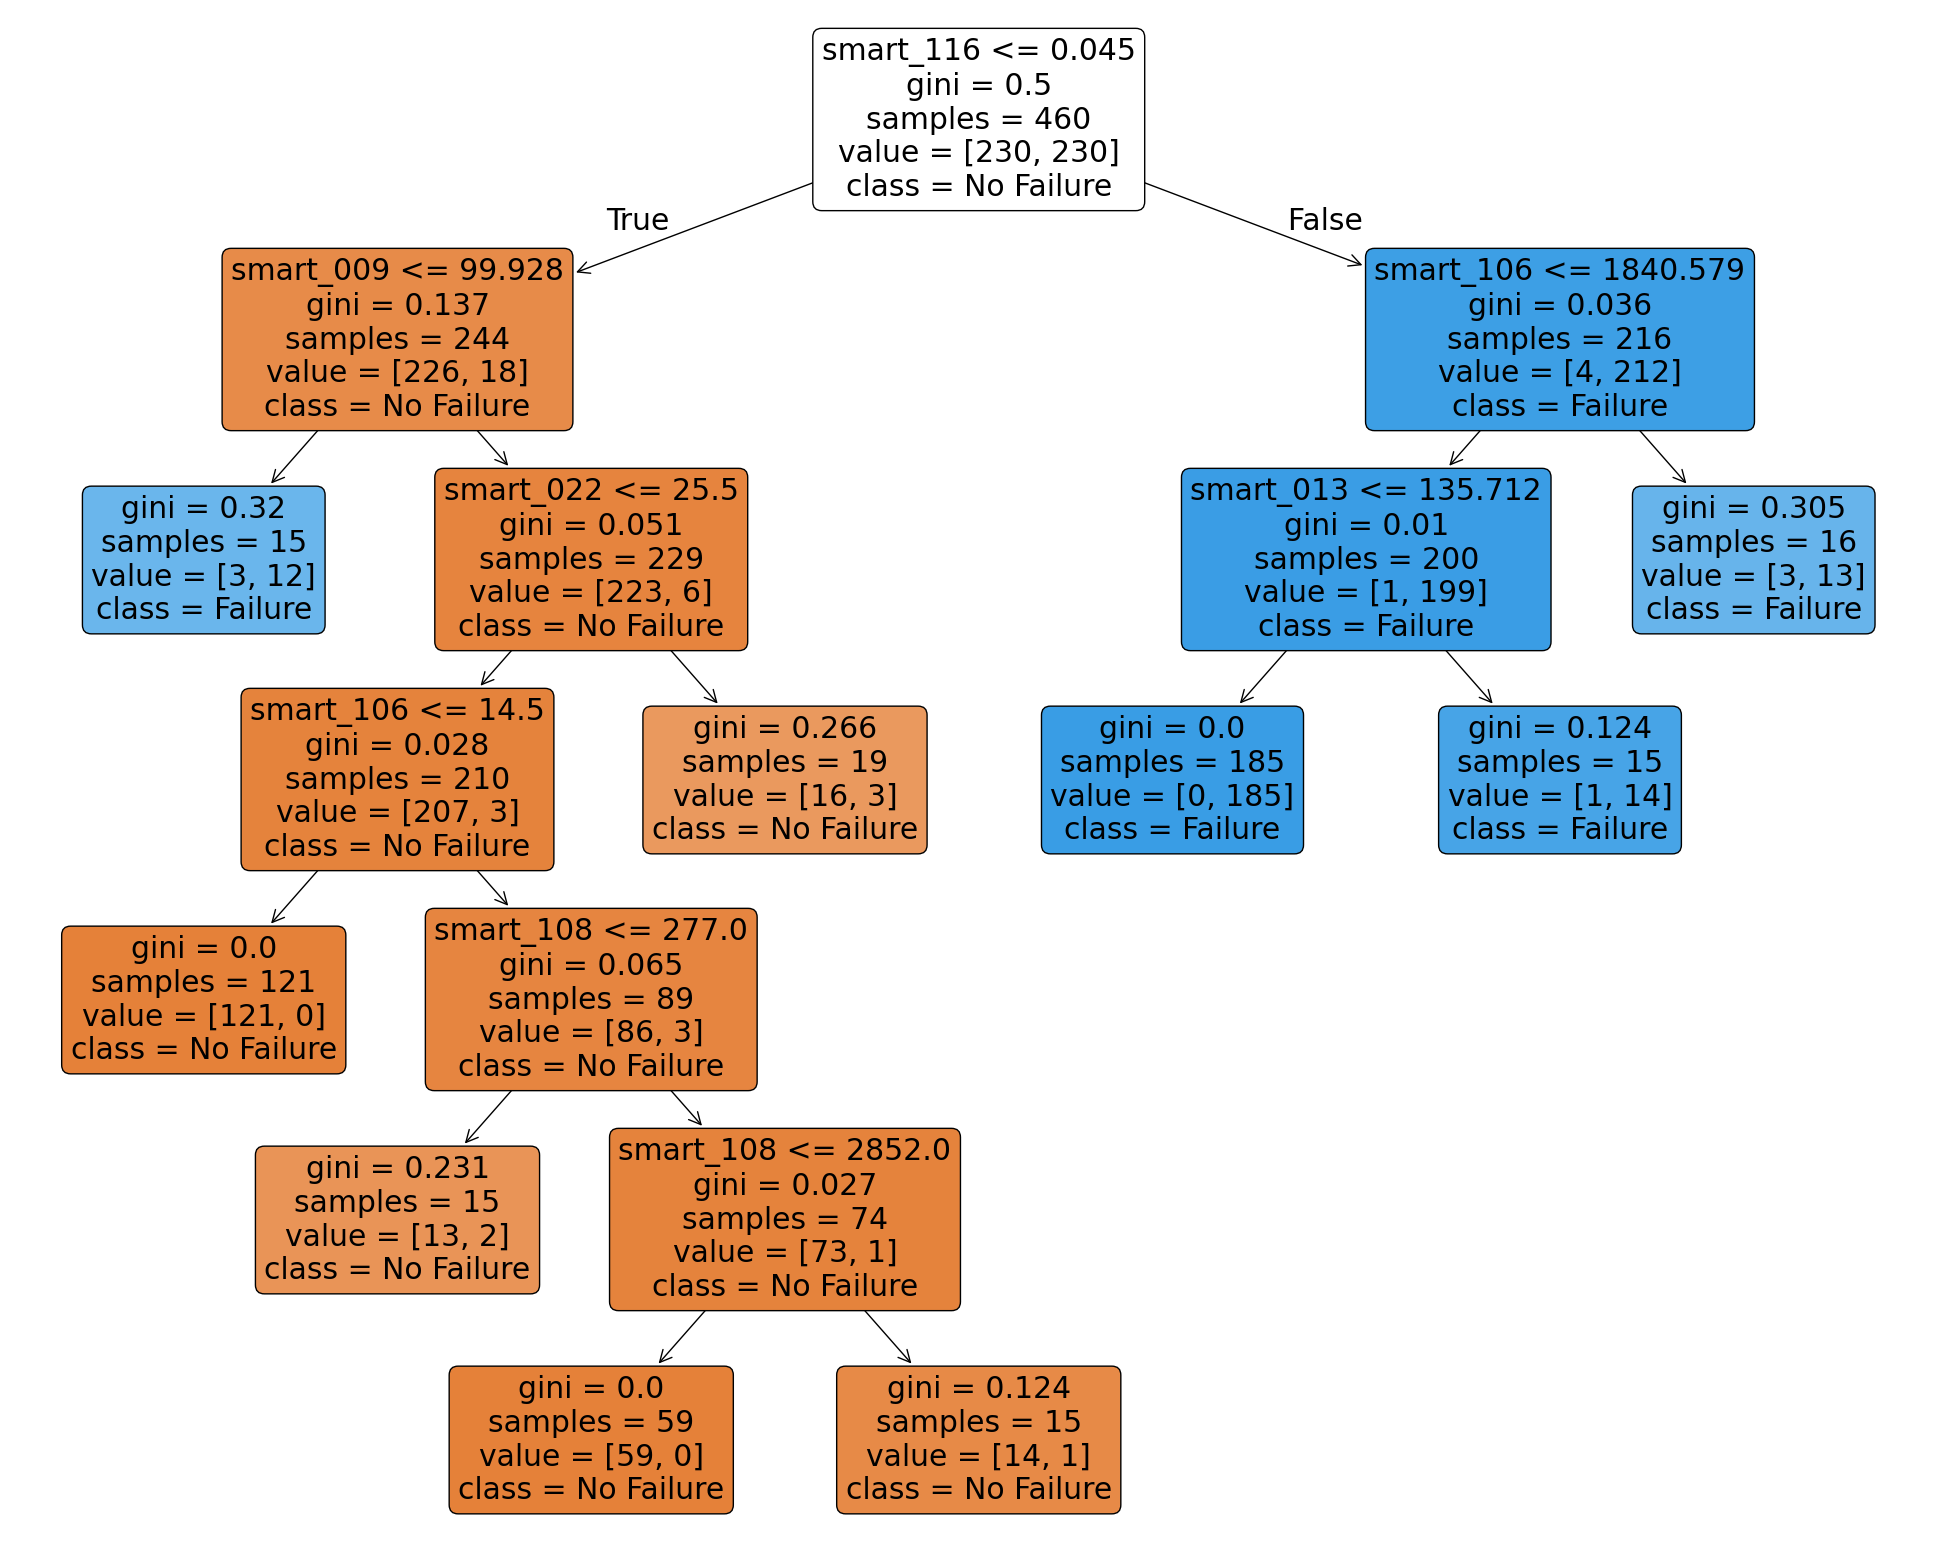

In [ ]:
CT.plot_decision_tree(clf_gini, smart_features, ['No Failure', 'Failure'])

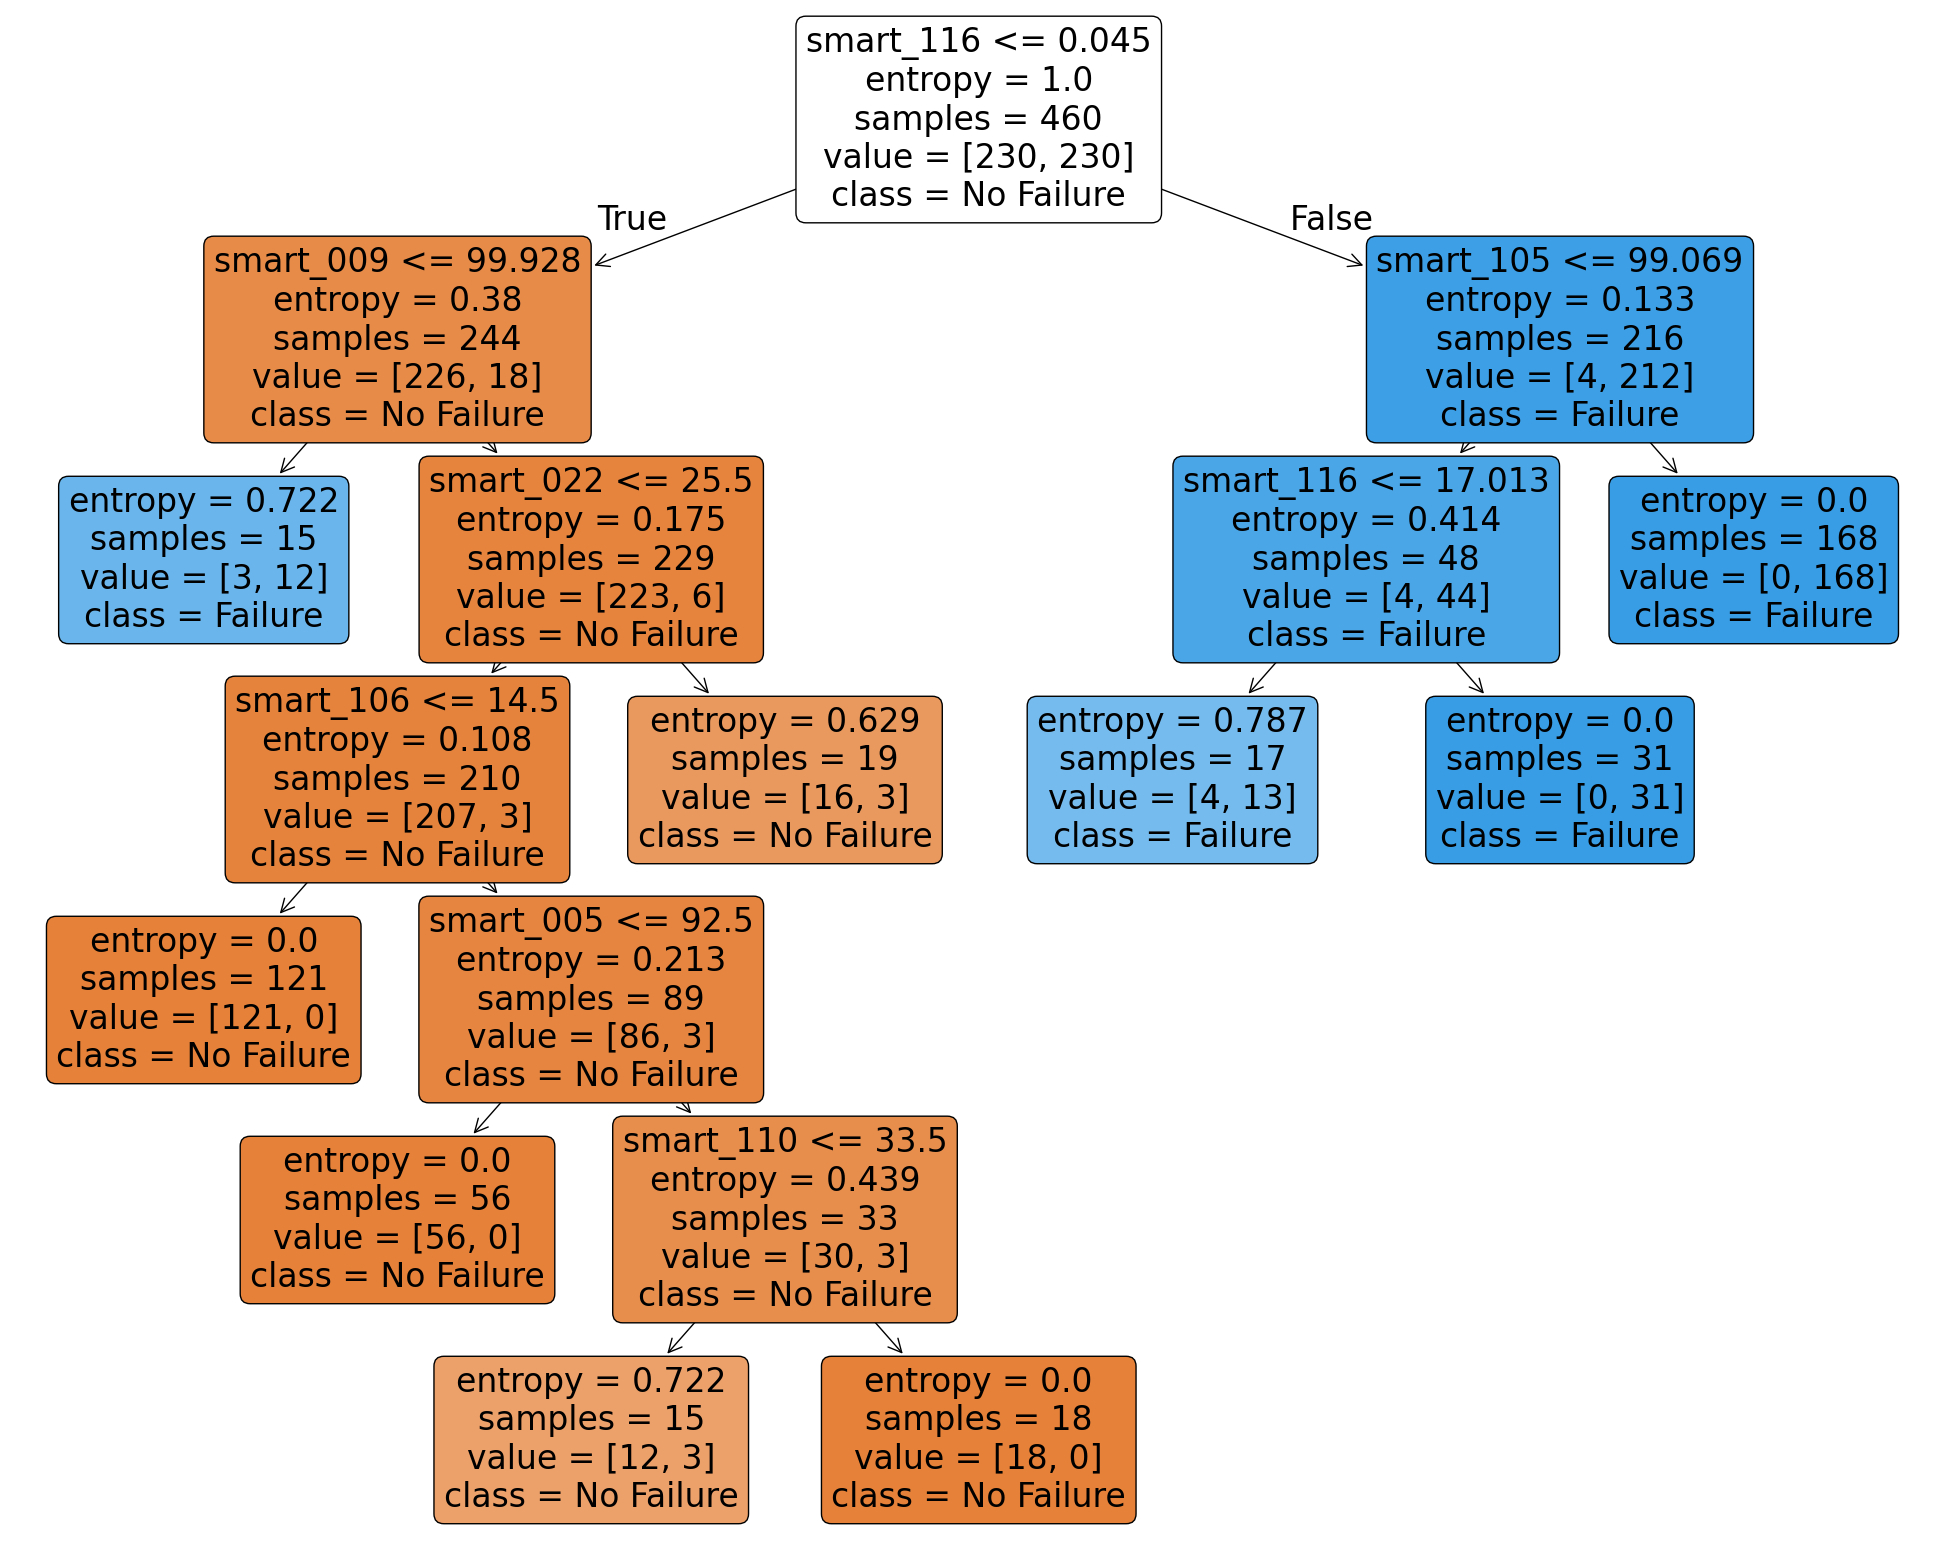

In [ ]:
CT.plot_decision_tree(clf_entropy, smart_features, ['No Failure', 'Failure'])

### Now we will predict a hard drive with the lstm and consume it and classify the prediction result with the CT

In [ ]:
path = "../data/data_test"
verbose = True    # Create a single data loader that handles the train/test split properly
model_path = 'models/LSTM/lstm_model.pth'
dataset_path = "../data/data_test"
output_path = "../pipeline/lstm_predictions_3drives_7days.csv"


We load all the data to choose randomly drives to generate predictions from

In [ ]:
num_drives = 5 # We will drive only one drive for testing purposes
data_loader = smart.DriveDataLoader(root=path, 
                                train_ratio=0.01, # we are going to use only the testing data
                                min_sequence_length=min_sequence_length + 1,  # to have 1 day to test  
                                verbose=verbose, num_drives=num_drives)

[DriveDataLoader] Loading drives with at least 6 days of data...
[DriveDataLoader] Found 0 subfolders in ../data/data_test.


Loading CSV files:  17%|█▋        | 1/6 [00:04<00:21,  4.36s/it]

Loaded ../data/data_test\2024-10-01.csv with shape (292679, 189)


Loading CSV files:  33%|███▎      | 2/6 [00:08<00:17,  4.41s/it]

Loaded ../data/data_test\2024-10-02.csv with shape (292648, 189)


Loading CSV files:  50%|█████     | 3/6 [00:13<00:13,  4.45s/it]

Loaded ../data/data_test\2024-10-03.csv with shape (292662, 189)


Loading CSV files:  67%|██████▋   | 4/6 [00:17<00:08,  4.38s/it]

Loaded ../data/data_test\2024-10-04.csv with shape (292694, 189)


Loading CSV files:  83%|████████▎ | 5/6 [00:21<00:04,  4.38s/it]

Loaded ../data/data_test\2024-10-05.csv with shape (292693, 189)


Loading CSV files: 100%|██████████| 6/6 [00:26<00:00,  4.38s/it]

Loaded ../data/data_test\2024-10-06.csv with shape (292683, 189)
[DriveDataLoader] Columns in data: ['date', 'serial_number', 'failure', 'smart_1_normalized', 'smart_1_raw', 'smart_2_normalized', 'smart_2_raw', 'smart_3_normalized', 'smart_3_raw', 'smart_4_normalized', 'smart_4_raw', 'smart_5_normalized', 'smart_5_raw', 'smart_7_normalized', 'smart_7_raw', 'smart_8_normalized', 'smart_8_raw', 'smart_9_normalized', 'smart_9_raw', 'smart_10_normalized', 'smart_10_raw', 'smart_11_normalized', 'smart_11_raw', 'smart_12_normalized', 'smart_12_raw', 'smart_13_normalized', 'smart_13_raw', 'smart_15_normalized', 'smart_15_raw', 'smart_16_normalized', 'smart_16_raw', 'smart_17_normalized', 'smart_17_raw', 'smart_18_normalized', 'smart_18_raw', 'smart_22_normalized', 'smart_22_raw', 'smart_23_normalized', 'smart_23_raw', 'smart_24_normalized', 'smart_24_raw', 'smart_27_normalized', 'smart_27_raw', 'smart_71_normalized', 'smart_71_raw', 'smart_82_normalized', 'smart_82_raw', 'smart_90_normalized'

[DriveDataLoader] Loaded 1756059 rows from all CSV files. DataFrame shape: (1756059, 189)
[DriveDataLoader] Selected 5 drives for processing.
[DriveDataLoader] Total rows in selected drives: 30


In [ ]:
selected_drives = data_loader.get_all_data()

print(f"Loaded {len(selected_drives)} days from the dataset from {num_drives} drives.")


Loaded 30 days from the dataset from 5 drives.


In [ ]:
# Extract the last day for each drive and store in a DataFrame
last_days_df = selected_drives.groupby('serial_number').tail(1).reset_index(drop=True)
print(last_days_df)

         date serial_number  failure  smart_1_normalized  smart_1_raw  \
0  2024-10-06  1290A00UFVKG    False                 100            0   
1  2024-10-06      2BJBXVTD    False                 100            0   
2  2024-10-06      3FJK4LNT    False                 100            0   
3  2024-10-06      ZA189J2B    False                  80    112110232   
4  2024-10-06      ZL2LFYC2    False                 100       228192   

   smart_2_normalized  smart_2_raw  smart_3_normalized  smart_3_raw  \
0                 100            0                 100         8159   
1                 100           96                  83          337   
2                 136           96                  90           71   
3                   0            0                  89            0   
4                   0            0                  95            0   

   smart_4_normalized  ...  smart_250_normalized  smart_250_raw  \
0                 100  ...                     0              0   


In [ ]:
model_path = 'models/LSTM/lstm_model.pth'
model, model_metrics = smart.load_model(model_path, device, load_whole_model=True)

✅ Complete model loaded from models/LSTM/lstm_model.joblib
✅ Model metrics loaded from models/LSTM/lstm_model_metrics.json


In [ ]:
model.eval()

Net(
  (lstm): LSTM(10, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=20, bias=True)
)

In [ ]:
ct_feature_list = [
    'serial_number', 'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_5_raw',
    'smart_7_normalized', 'smart_9_normalized', 'smart_187_normalized',
    'smart_189_normalized', 'smart_190_normalized', 'smart_195_normalized',
    'smart_197_normalized', 'smart_197_raw'
]
predicted_info = pd.DataFrame(columns=ct_feature_list)

In [ ]:

for serial, drive_df in tqdm(selected_drives.groupby('serial_number'), desc="Processing drives"):
    # Prepare your input sequence for the LSTM
    features = drive_df.drop(columns=['serial_number', 'date', 'failure']).values
    # Convert to tensor and add batch/sequence dimensions as needed, and use float64
    input_tensor = torch.tensor(features, dtype=torch.float64).unsqueeze(0)  # shape: [1, seq_len, features]
    # Run through model
    with torch.no_grad():
        prediction = model(input_tensor.to(device))
        last_day_pred = prediction[:, -1, :].cpu().numpy().flatten()
        # Map last_day_pred to ct_feature_list and append to predicted_info
        pred_row = dict(zip(ct_feature_list, last_day_pred))
        pred_row['serial_number'] = serial
        predicted_info = pd.concat([predicted_info, pd.DataFrame([pred_row], columns=predicted_info.columns)], ignore_index=True)

Processing drives:   0%|          | 0/5 [00:00<?, ?it/s]


RuntimeError: input.size(-1) must be equal to input_size. Expected 10, got 186

In [ ]:
print(predicted_info)

  serial_number  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
0  6210A0QHFVKG           99.273760           99.901448            0.083744   
1      ZGG4HPHA           99.277400           99.904743            0.084348   
2      ZL22ZX61           95.121698          100.644906            7.974944   
3      ZL2CPA4Y           95.121698          100.644906            7.974944   
4      ZLW0G67X           95.121698          100.644906            7.974944   

   smart_5_raw  smart_7_normalized  smart_9_normalized  smart_187_normalized  \
0    99.357731           69.222424           17.205635             -0.184223   
1    99.360541           69.224986           17.208494             -0.183362   
2    88.383509           63.490517           61.740422             21.370746   
3    88.383509           63.490517           61.740422             21.370746   
4    88.383509           63.490517           61.740422             21.370746   

   smart_189_normalized  smart_190_normalize

In [ ]:

clf_gini = load("models/DT/best_gini_tree.joblib")
clf_entropy = load("models/DT/best_entropy_tree.joblib")

In [ ]:
serial_numbers = predicted_info['serial_number'].unique()
# predicted_info = predicted_info.drop(columns=['serial_number'])

In [ ]:
# Only use the feature columns for prediction to avoid warnings
feature_cols = [
	'smart_1_normalized', 'smart_3_normalized', 'smart_5_normalized', 'smart_5_raw',
	'smart_7_normalized', 'smart_9_normalized', 'smart_187_normalized',
	'smart_189_normalized', 'smart_190_normalized', 'smart_195_normalized',
	'smart_197_normalized', 'smart_197_raw'
]
ct_predictions = CT.prediction(predicted_info[feature_cols].values, clf_gini)

# Add predictions to the DataFrame
predicted_info['CT_Drive_Failed'] = ct_predictions
print(predicted_info)


Predicted values:
[ True  True  True  True  True]
  serial_number  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
0  6210A0QHFVKG           99.273760           99.901448            0.083744   
1      ZGG4HPHA           99.277400           99.904743            0.084348   
2      ZL22ZX61           95.121698          100.644906            7.974944   
3      ZL2CPA4Y           95.121698          100.644906            7.974944   
4      ZLW0G67X           95.121698          100.644906            7.974944   

   smart_5_raw  smart_7_normalized  smart_9_normalized  smart_187_normalized  \
0    99.357731           69.222424           17.205635             -0.184223   
1    99.360541           69.224986           17.208494             -0.183362   
2    88.383509           63.490517           61.740422             21.370746   
3    88.383509           63.490517           61.740422             21.370746   
4    88.383509           63.490517           61.740422             21.37074

In [ ]:

# Compare predicted failure with actual failure for each drive
last_days_df_sorted = last_days_df.set_index('serial_number').loc[serial_numbers].reset_index()
predicted_info['Actual_Failure'] = last_days_df_sorted['failure'].values

# Optionally, print a comparison summary
comparison = predicted_info[['CT_Drive_Failed', 'Actual_Failure']]
print("Prediction vs Actual Failure:\n", comparison)

print("accuracy:", (predicted_info['CT_Drive_Failed'] == predicted_info['Actual_Failure']).mean())



Prediction vs Actual Failure:
    CT_Drive_Failed  Actual_Failure
0             True           False
1             True           False
2             True           False
3             True           False
4             True           False
accuracy: 0.0
